In [1]:
import drawing
import imp
imp.reload(drawing)

<module 'drawing' from '/u/home/lyrebird_code/handwriting_synthesis/drawing.py'>

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:1


In [3]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-1] = strokes[i][1:lengths[i], 0:2]
        idx += lengths[i] - 1
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i], 0:2] -= means
        result[i, 1:lengths[i], 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i], 0:2] *= std
        result[i, 1:lengths[i], 0:2] += means
    return result


In [5]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


# should ideally be a transform in the model itself
strokes, means, std = standarize(strokes_og, stroke_lens) # we will need these means and std later on to denormalize
res2 = destandarize(strokes, stroke_lens, means, std) # for checking
(res2 - strokes_og).sum() # should be a small value

0.0064151324

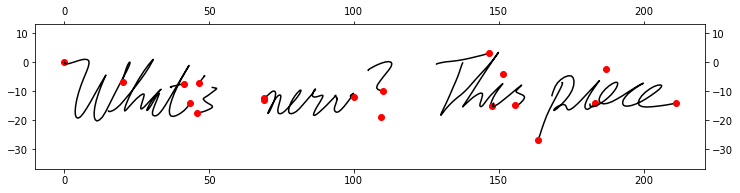

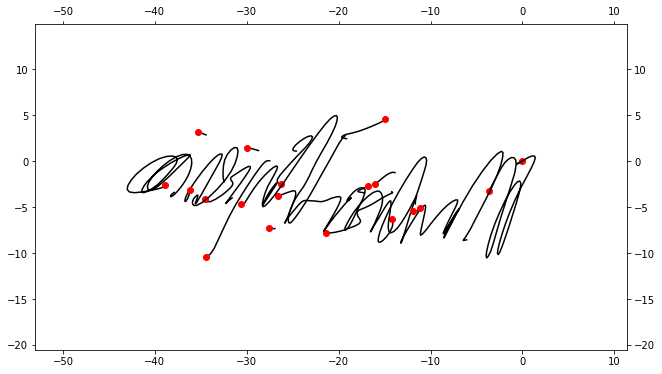

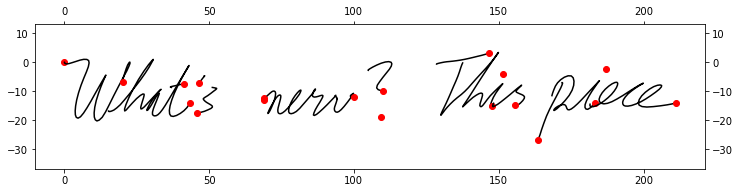

What 's new? This piece


In [6]:
draw(strokes_og[0])
draw(strokes[0])
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [7]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [8]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            mask[i][self.stroke_lengths[i]:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


/home/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627542741873/work/build/aten/src/ATen/core/TensorBody.h:802.)
  return self._grad


n_iter: 0 of 15600, loss: 40.380986328125, timeElapsed: 5.419069528579712


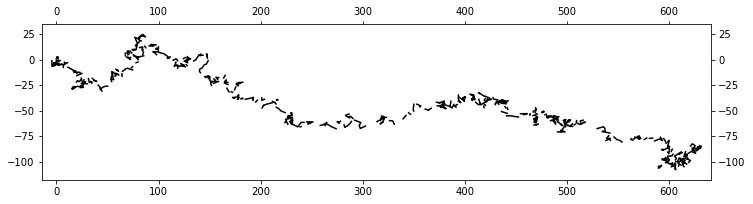

n_iter: 50 of 15600, loss: 1917.5681591796874, timeElapsed: 139.88765788078308
n_iter: 100 of 15600, loss: 1869.1836596679686, timeElapsed: 272.73018503189087
n_iter: 150 of 15600, loss: 1675.6799438476562, timeElapsed: 404.6801600456238
n_iter: 200 of 15600, loss: 1037.0972570800782, timeElapsed: 536.9704926013947


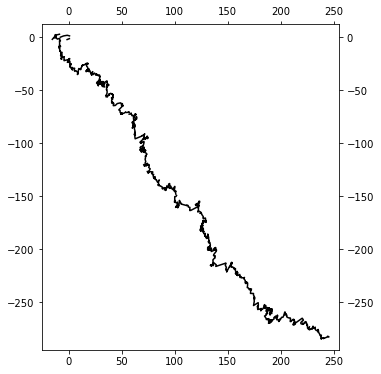

n_iter: 250 of 15600, loss: 893.7773059082032, timeElapsed: 672.1240708827972
n_iter: 300 of 15600, loss: 837.2754113769531, timeElapsed: 804.6000969409943
n_iter: 350 of 15600, loss: 828.1982006835938, timeElapsed: 936.8685646057129
n_iter: 400 of 15600, loss: 812.46728515625, timeElapsed: 1069.098747253418


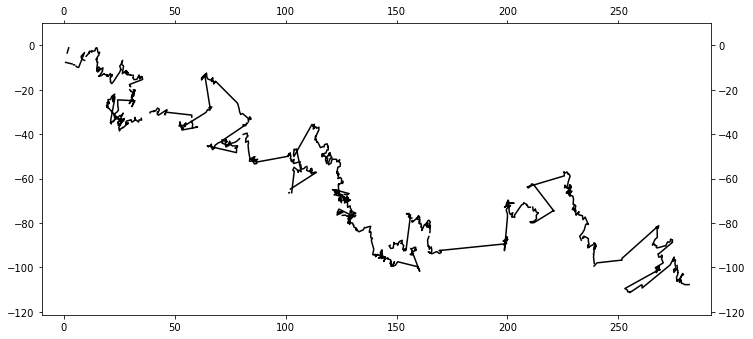

n_iter: 450 of 15600, loss: 809.2268908691407, timeElapsed: 1204.4612081050873
n_iter: 500 of 15600, loss: 788.573017578125, timeElapsed: 1337.22607755661
n_iter: 550 of 15600, loss: 781.900263671875, timeElapsed: 1469.5293476581573
n_iter: 600 of 15600, loss: 756.5022741699219, timeElapsed: 1601.9126510620117


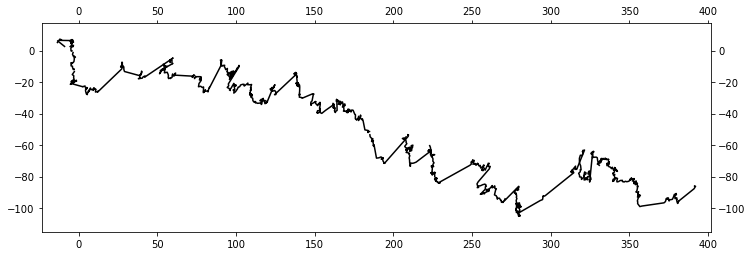

n_iter: 650 of 15600, loss: 711.0778686523438, timeElapsed: 1735.4160723686218
n_iter: 700 of 15600, loss: 652.7714111328125, timeElapsed: 1868.8664245605469
n_iter: 750 of 15600, loss: 611.7176525878906, timeElapsed: 2001.176847934723
n_iter: 800 of 15600, loss: 591.15962890625, timeElapsed: 2135.2771503925323


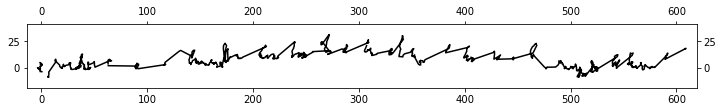

n_iter: 850 of 15600, loss: 563.1799523925781, timeElapsed: 2269.6568875312805
n_iter: 900 of 15600, loss: 537.4688995361328, timeElapsed: 2401.3538148403168
n_iter: 950 of 15600, loss: 523.421978149414, timeElapsed: 2534.9354515075684
n_iter: 1000 of 15600, loss: 501.286435546875, timeElapsed: 2666.1686317920685


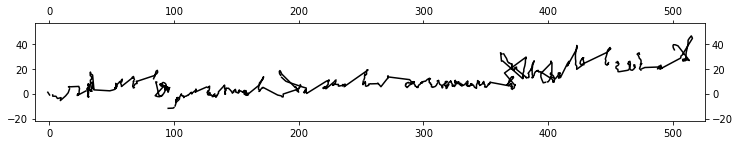

n_iter: 1050 of 15600, loss: 482.7173681640625, timeElapsed: 2800.0071976184845
n_iter: 1100 of 15600, loss: 467.71541564941407, timeElapsed: 2932.7829899787903
n_iter: 1150 of 15600, loss: 442.3018518066406, timeElapsed: 3065.2667801380157
n_iter: 1200 of 15600, loss: 424.7863067626953, timeElapsed: 3198.649397611618


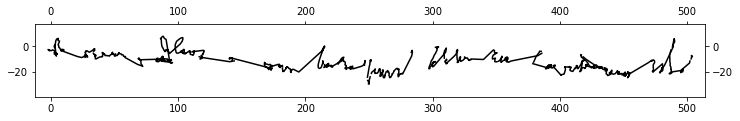

n_iter: 1250 of 15600, loss: 405.880703125, timeElapsed: 3332.5450146198273
n_iter: 1300 of 15600, loss: 387.23235412597654, timeElapsed: 3465.164235830307
n_iter: 1350 of 15600, loss: 362.6660461425781, timeElapsed: 3597.894622564316
n_iter: 1400 of 15600, loss: 344.4388555908203, timeElapsed: 3731.7829463481903


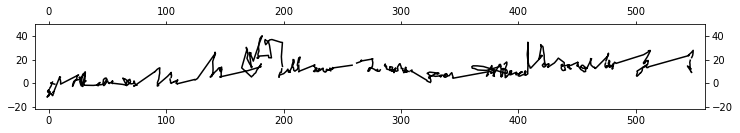

n_iter: 1450 of 15600, loss: 326.66918518066404, timeElapsed: 3867.4889512062073
n_iter: 1500 of 15600, loss: 304.78290618896483, timeElapsed: 3999.7700293064117
n_iter: 1550 of 15600, loss: 285.9606823730469, timeElapsed: 4132.823073625565
n_iter: 1600 of 15600, loss: 265.8510760498047, timeElapsed: 4264.376835823059


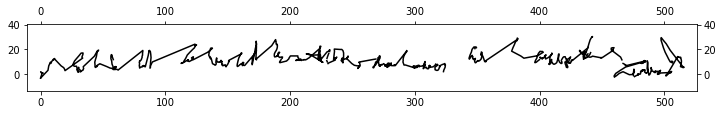

n_iter: 1650 of 15600, loss: 249.51409210205077, timeElapsed: 4398.490807056427
n_iter: 1700 of 15600, loss: 229.59381469726563, timeElapsed: 4531.978003501892
n_iter: 1750 of 15600, loss: 207.5294512939453, timeElapsed: 4665.029493808746
n_iter: 1800 of 15600, loss: 193.84774139404297, timeElapsed: 4797.934239387512


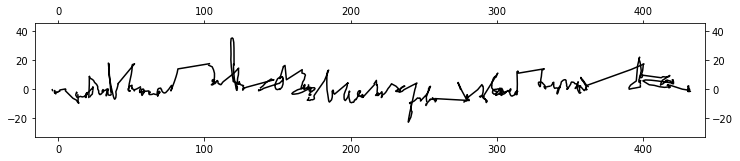

n_iter: 1850 of 15600, loss: 174.67117218017577, timeElapsed: 4931.501526355743
n_iter: 1900 of 15600, loss: 155.7990657043457, timeElapsed: 5064.116261720657
n_iter: 1950 of 15600, loss: 141.82550048828125, timeElapsed: 5197.632858276367
n_iter: 2000 of 15600, loss: 126.15835754394531, timeElapsed: 5330.946522474289


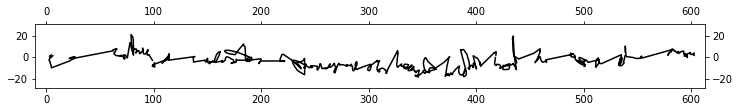

n_iter: 2050 of 15600, loss: 108.38709045410157, timeElapsed: 5465.681221008301
n_iter: 2100 of 15600, loss: 92.41929946899414, timeElapsed: 5598.023591756821
n_iter: 2150 of 15600, loss: 74.16668167114258, timeElapsed: 5730.6709406375885
n_iter: 2200 of 15600, loss: 68.53191035270692, timeElapsed: 5864.2400143146515


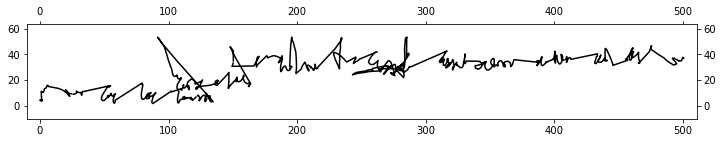

n_iter: 2250 of 15600, loss: 46.283865442276, timeElapsed: 5997.8713455200195
n_iter: 2300 of 15600, loss: 35.25863129615784, timeElapsed: 6131.072343587875
n_iter: 2350 of 15600, loss: 23.679192573428153, timeElapsed: 6263.642836332321
n_iter: 2400 of 15600, loss: 9.00875515460968, timeElapsed: 6397.021411180496


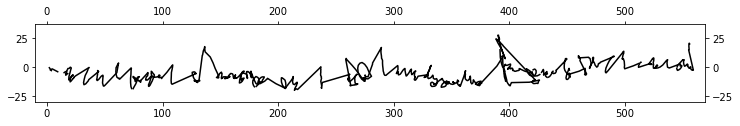

n_iter: 2450 of 15600, loss: -1.221581785082817, timeElapsed: 6531.378699541092
n_iter: 2500 of 15600, loss: -11.313188209533692, timeElapsed: 6664.345636606216
n_iter: 2550 of 15600, loss: -29.464237577915192, timeElapsed: 6797.129306793213
n_iter: 2600 of 15600, loss: -32.8120752120018, timeElapsed: 6930.206701993942


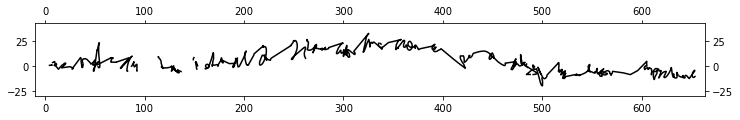

n_iter: 2650 of 15600, loss: -48.06799282073975, timeElapsed: 7064.856425046921
n_iter: 2700 of 15600, loss: -61.0023272895813, timeElapsed: 7197.909202814102
n_iter: 2750 of 15600, loss: -64.94019218921662, timeElapsed: 7331.852628946304
n_iter: 2800 of 15600, loss: -79.97875442504883, timeElapsed: 7465.502014875412


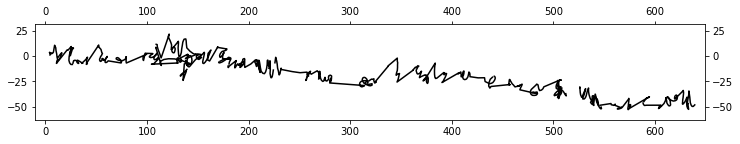

n_iter: 2850 of 15600, loss: -96.1552571105957, timeElapsed: 7599.825263261795
n_iter: 2900 of 15600, loss: -103.73592819213867, timeElapsed: 7733.5228843688965
n_iter: 2950 of 15600, loss: -117.36521339416504, timeElapsed: 7866.625364303589
n_iter: 3000 of 15600, loss: -126.8270238494873, timeElapsed: 8000.24920463562


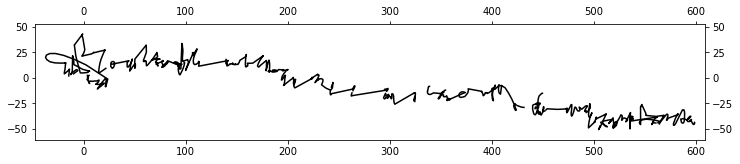

n_iter: 3050 of 15600, loss: -136.2349089050293, timeElapsed: 8134.57305264473
n_iter: 3100 of 15600, loss: -152.92621231079102, timeElapsed: 8268.303980350494
n_iter: 3150 of 15600, loss: -168.6583154296875, timeElapsed: 8401.127158403397
n_iter: 3200 of 15600, loss: -176.52548446655274, timeElapsed: 8535.031351327896


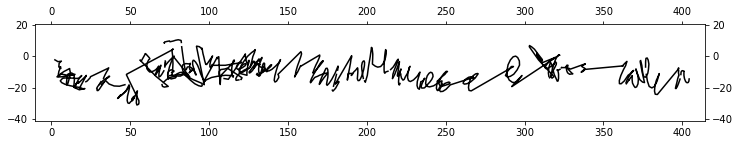

n_iter: 3250 of 15600, loss: -188.09137725830078, timeElapsed: 8668.930418491364
n_iter: 3300 of 15600, loss: -204.68461624145507, timeElapsed: 8802.361248731613
n_iter: 3350 of 15600, loss: -212.39565734863282, timeElapsed: 8934.356719970703
n_iter: 3400 of 15600, loss: -224.51297271728515, timeElapsed: 9067.474310159683


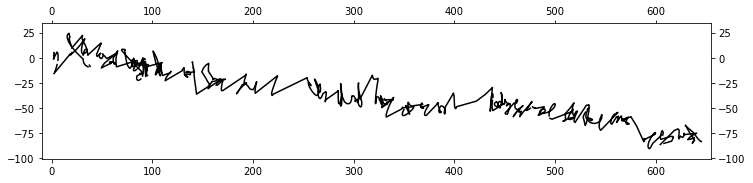

n_iter: 3450 of 15600, loss: -236.33321838378907, timeElapsed: 9202.14473772049
n_iter: 3500 of 15600, loss: -245.07820098876954, timeElapsed: 9334.981199264526
n_iter: 3550 of 15600, loss: -252.90830963134766, timeElapsed: 9468.576686620712
n_iter: 3600 of 15600, loss: -268.8288607788086, timeElapsed: 9601.166458129883


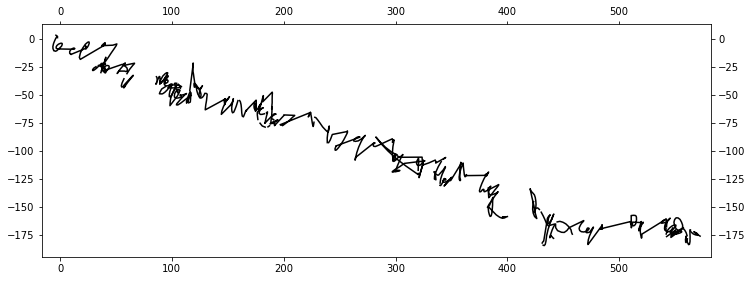

n_iter: 3650 of 15600, loss: -262.35154876708987, timeElapsed: 9735.269044399261
n_iter: 3700 of 15600, loss: -278.12053253173826, timeElapsed: 9868.907293081284
n_iter: 3750 of 15600, loss: -293.26717651367187, timeElapsed: 10002.47928071022
n_iter: 3800 of 15600, loss: -300.25390258789065, timeElapsed: 10135.736787557602


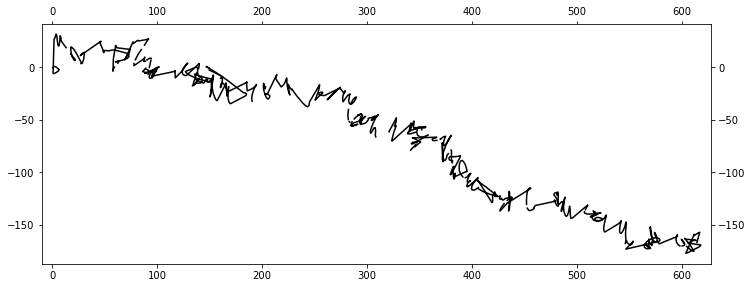

n_iter: 3850 of 15600, loss: -305.3604635620117, timeElapsed: 10270.972720623016
n_iter: 3900 of 15600, loss: -317.37742614746094, timeElapsed: 10403.58055305481
n_iter: 3950 of 15600, loss: -328.8143585205078, timeElapsed: 10536.051921129227
n_iter: 4000 of 15600, loss: -324.7025274658203, timeElapsed: 10667.631124019623


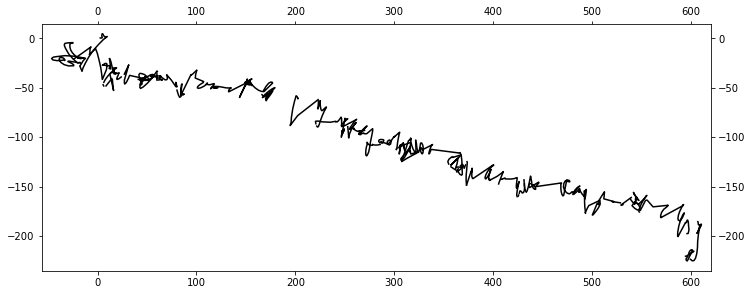

n_iter: 4050 of 15600, loss: -342.4421368408203, timeElapsed: 10801.880112886429
n_iter: 4100 of 15600, loss: -346.17659729003907, timeElapsed: 10934.114451169968
n_iter: 4150 of 15600, loss: -356.4498809814453, timeElapsed: 11066.999394416809
n_iter: 4200 of 15600, loss: -363.0551489257812, timeElapsed: 11200.543339967728


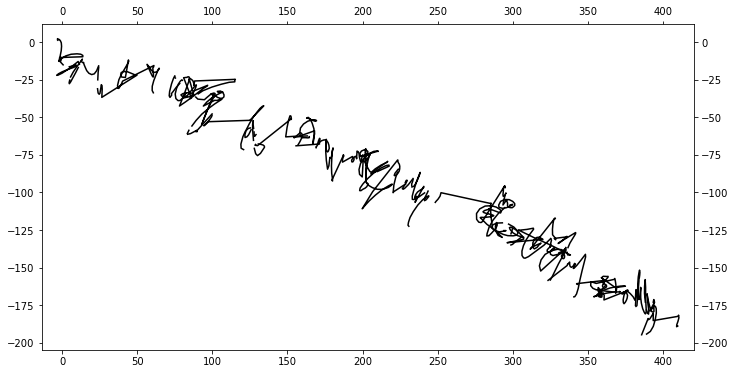

n_iter: 4250 of 15600, loss: -370.81068298339846, timeElapsed: 11334.80046749115
n_iter: 4300 of 15600, loss: -386.52266174316406, timeElapsed: 11467.714530467987
n_iter: 4350 of 15600, loss: -388.21716674804685, timeElapsed: 11600.87361907959
n_iter: 4400 of 15600, loss: -399.049951171875, timeElapsed: 11734.80479836464


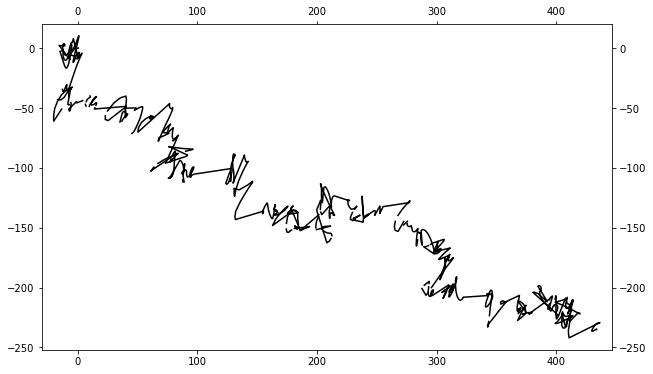

n_iter: 4450 of 15600, loss: -401.10971923828123, timeElapsed: 11868.659669160843
n_iter: 4500 of 15600, loss: -413.6647723388672, timeElapsed: 12001.596415042877
n_iter: 4550 of 15600, loss: -417.8247528076172, timeElapsed: 12134.694695234299
n_iter: 4600 of 15600, loss: -427.5386975097656, timeElapsed: 12267.889486074448


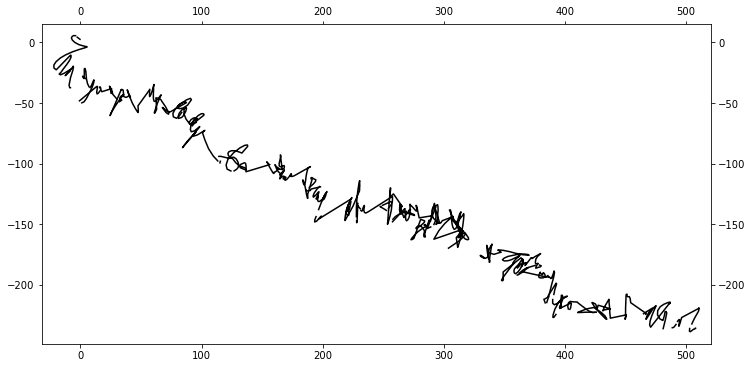

n_iter: 4650 of 15600, loss: -437.22453552246094, timeElapsed: 12401.703031539917
n_iter: 4700 of 15600, loss: -440.3856567382812, timeElapsed: 12535.26374411583
n_iter: 4750 of 15600, loss: -452.42271484375, timeElapsed: 12668.531688690186
n_iter: 4800 of 15600, loss: -452.0033740234375, timeElapsed: 12802.250213861465


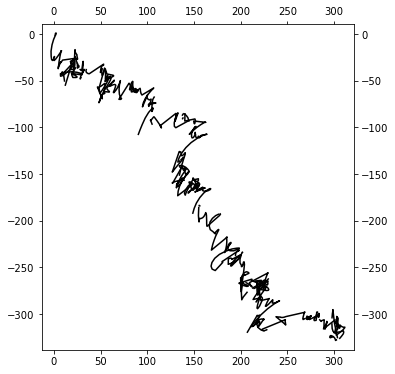

n_iter: 4850 of 15600, loss: -467.83582946777346, timeElapsed: 12936.978656053543
n_iter: 4900 of 15600, loss: -469.7115637207031, timeElapsed: 13070.248799324036
n_iter: 4950 of 15600, loss: -477.83280517578123, timeElapsed: 13204.021979570389
n_iter: 5000 of 15600, loss: -477.38615966796874, timeElapsed: 13337.503275871277


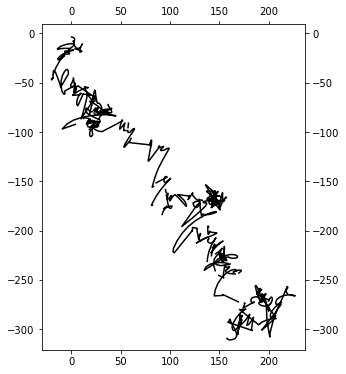

n_iter: 5050 of 15600, loss: -484.4535845947266, timeElapsed: 13472.040603876114
n_iter: 5100 of 15600, loss: -494.5798101806641, timeElapsed: 13604.642463445663
n_iter: 5150 of 15600, loss: -505.2335272216797, timeElapsed: 13737.445214986801
n_iter: 5200 of 15600, loss: -506.0401306152344, timeElapsed: 13871.069374799728


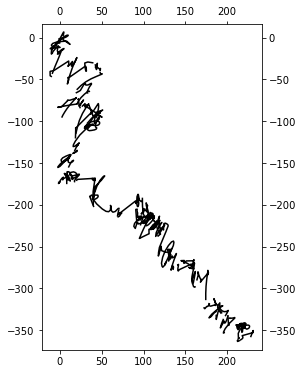

n_iter: 5250 of 15600, loss: -511.12547607421874, timeElapsed: 14004.175166130066
n_iter: 5300 of 15600, loss: -516.2545599365235, timeElapsed: 14137.344550848007
n_iter: 5350 of 15600, loss: -522.2752081298828, timeElapsed: 14270.366394281387
n_iter: 5400 of 15600, loss: -526.2726788330078, timeElapsed: 14403.18420624733


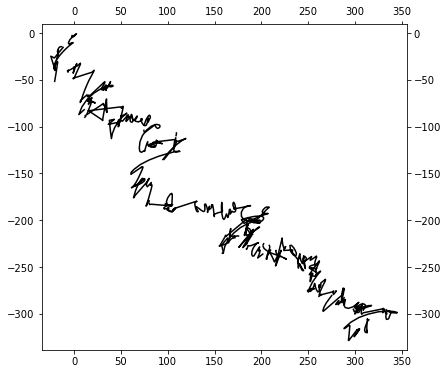

n_iter: 5450 of 15600, loss: -530.2164251708984, timeElapsed: 14538.533217430115
n_iter: 5500 of 15600, loss: -535.7152575683593, timeElapsed: 14672.023433685303
n_iter: 5550 of 15600, loss: -538.556083984375, timeElapsed: 14804.996059656143
n_iter: 5600 of 15600, loss: -540.6781921386719, timeElapsed: 14938.255872011185


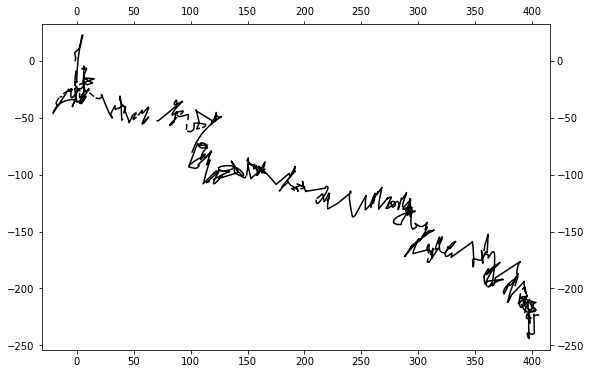

n_iter: 5650 of 15600, loss: -552.4048114013672, timeElapsed: 15072.729882478714
n_iter: 5700 of 15600, loss: -552.8750787353515, timeElapsed: 15206.097428798676
n_iter: 5750 of 15600, loss: -547.3038922119141, timeElapsed: 15338.24842095375
n_iter: 5800 of 15600, loss: -564.7129406738281, timeElapsed: 15472.0305519104


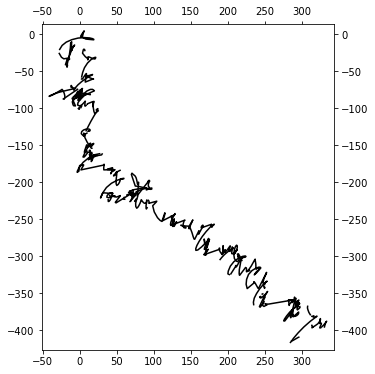

n_iter: 5850 of 15600, loss: -567.7020391845704, timeElapsed: 15606.935714483261
n_iter: 5900 of 15600, loss: -566.7576098632812, timeElapsed: 15740.337361574173
n_iter: 5950 of 15600, loss: -568.9749420166015, timeElapsed: 15873.977780103683
n_iter: 6000 of 15600, loss: -569.20435546875, timeElapsed: 16006.47629070282


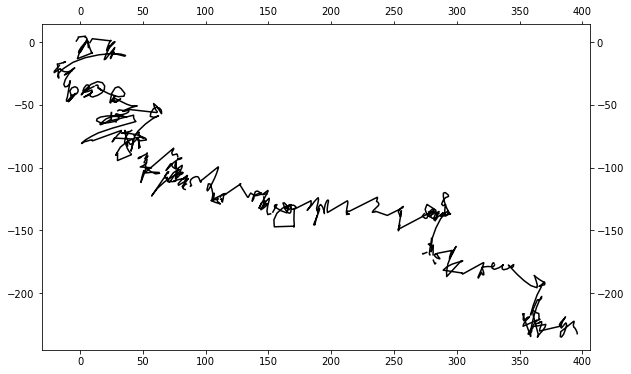

n_iter: 6050 of 15600, loss: -583.57232421875, timeElapsed: 16141.86045384407
n_iter: 6100 of 15600, loss: -568.6657153320313, timeElapsed: 16274.826128482819
n_iter: 6150 of 15600, loss: -581.4375952148438, timeElapsed: 16407.431599378586
n_iter: 6200 of 15600, loss: -581.7114678955078, timeElapsed: 16541.334146261215


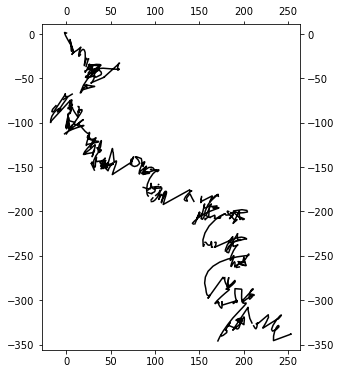

n_iter: 6250 of 15600, loss: -591.7693469238282, timeElapsed: 16676.39702486992
n_iter: 6300 of 15600, loss: -585.4315216064454, timeElapsed: 16808.826250076294
n_iter: 6350 of 15600, loss: -599.6947277832031, timeElapsed: 16941.782743692398
n_iter: 6400 of 15600, loss: -592.736845703125, timeElapsed: 17075.300763368607


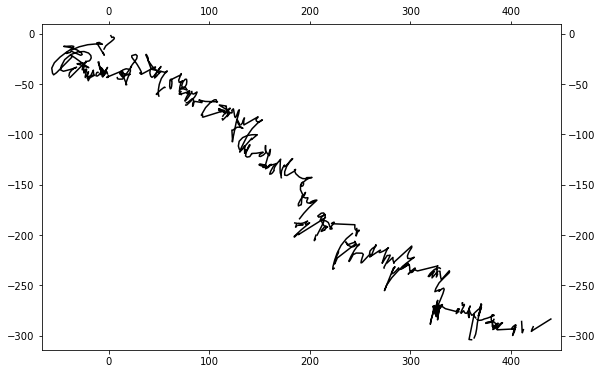

n_iter: 6450 of 15600, loss: -593.4779052734375, timeElapsed: 17209.794726371765
n_iter: 6500 of 15600, loss: -604.1893371582031, timeElapsed: 17344.428730249405
n_iter: 6550 of 15600, loss: -601.255439453125, timeElapsed: 17476.75139927864
n_iter: 6600 of 15600, loss: -608.2186096191406, timeElapsed: 17610.339787483215


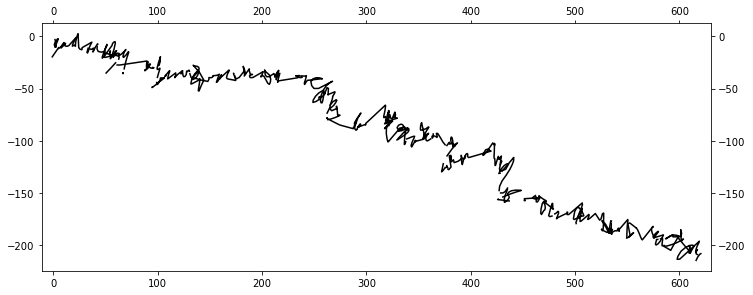

n_iter: 6650 of 15600, loss: -600.2970104980469, timeElapsed: 17745.156011104584
n_iter: 6700 of 15600, loss: -614.5648779296876, timeElapsed: 17879.834475517273
n_iter: 6750 of 15600, loss: -611.798408203125, timeElapsed: 18012.812965393066
n_iter: 6800 of 15600, loss: -608.7126245117188, timeElapsed: 18146.151683568954


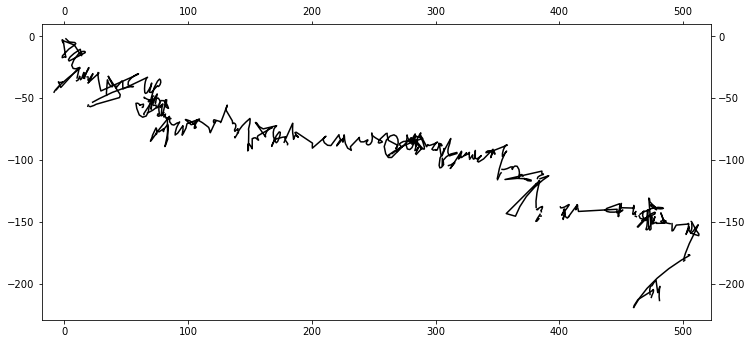

n_iter: 6850 of 15600, loss: -614.0225366210938, timeElapsed: 18280.877633571625
n_iter: 6900 of 15600, loss: -621.5293151855469, timeElapsed: 18414.071694374084
n_iter: 6950 of 15600, loss: -619.2233874511719, timeElapsed: 18546.166486740112
n_iter: 7000 of 15600, loss: -623.752080078125, timeElapsed: 18679.457060337067


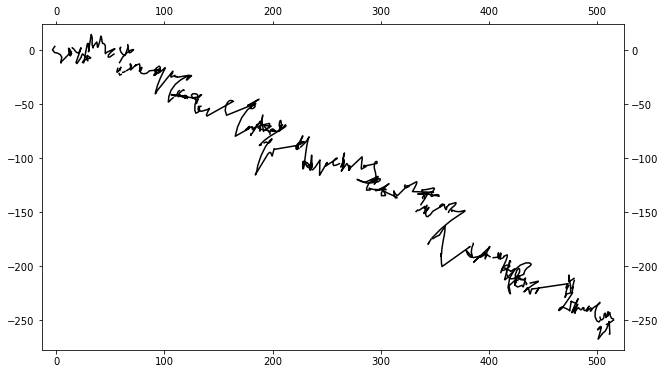

n_iter: 7050 of 15600, loss: -622.5351245117188, timeElapsed: 18814.601308822632
n_iter: 7100 of 15600, loss: -622.7666784667969, timeElapsed: 18948.768746852875
n_iter: 7150 of 15600, loss: -626.1451501464844, timeElapsed: 19081.85358285904
n_iter: 7200 of 15600, loss: -627.4070544433594, timeElapsed: 19214.600317955017


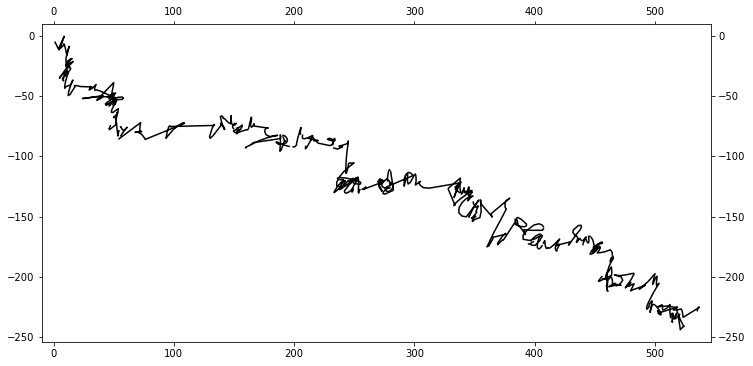

n_iter: 7250 of 15600, loss: -630.9134545898437, timeElapsed: 19349.780876636505
n_iter: 7300 of 15600, loss: -628.4142553710938, timeElapsed: 19482.394830942154
n_iter: 7350 of 15600, loss: -636.3888354492187, timeElapsed: 19616.393881082535
n_iter: 7400 of 15600, loss: -638.5537927246094, timeElapsed: 19748.51778125763


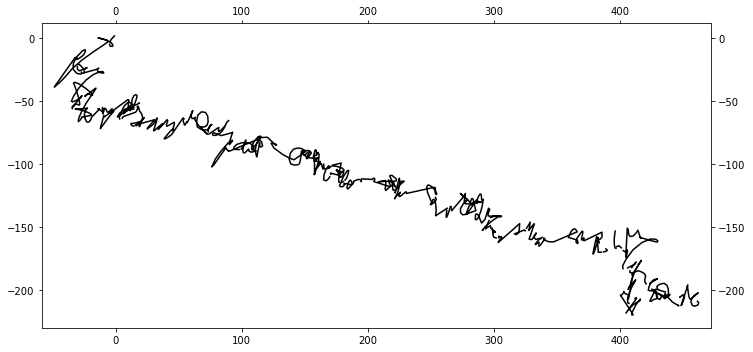

n_iter: 7450 of 15600, loss: -628.8207922363281, timeElapsed: 19884.112762451172
n_iter: 7500 of 15600, loss: -642.5983825683594, timeElapsed: 20016.40711903572
n_iter: 7550 of 15600, loss: -644.1496374511719, timeElapsed: 20149.480110406876
n_iter: 7600 of 15600, loss: -637.9669323730469, timeElapsed: 20283.509884119034


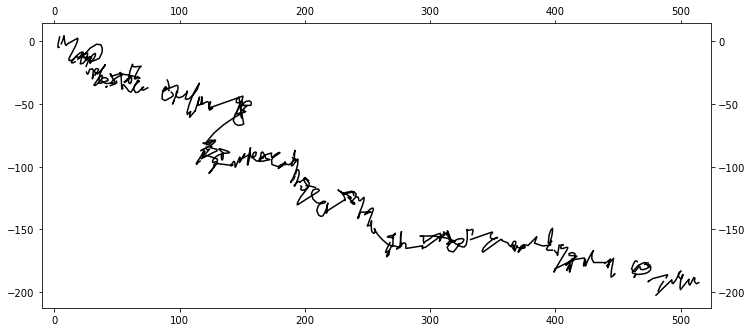

n_iter: 7650 of 15600, loss: -641.3003515625, timeElapsed: 20418.038542747498
n_iter: 7700 of 15600, loss: -654.3984057617188, timeElapsed: 20550.914328098297
n_iter: 7750 of 15600, loss: -636.2414782714844, timeElapsed: 20683.221435308456
n_iter: 7800 of 15600, loss: -647.70509765625, timeElapsed: 20816.80651116371


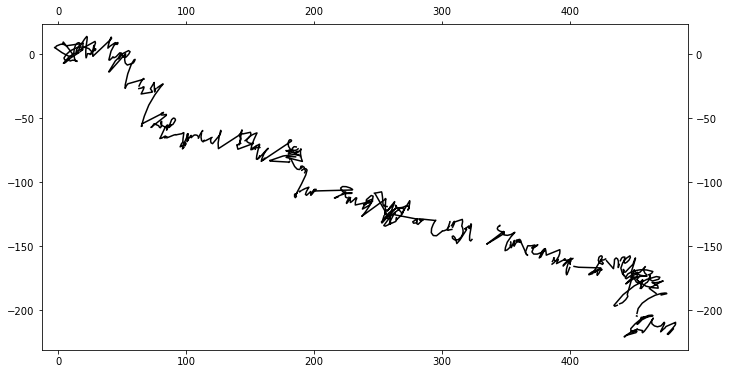

n_iter: 7850 of 15600, loss: -650.813505859375, timeElapsed: 20952.08136177063
n_iter: 7900 of 15600, loss: -641.6509582519532, timeElapsed: 21085.5722990036
n_iter: 7950 of 15600, loss: -660.5887316894531, timeElapsed: 21218.937435388565
n_iter: 8000 of 15600, loss: -647.250654296875, timeElapsed: 21351.151950597763


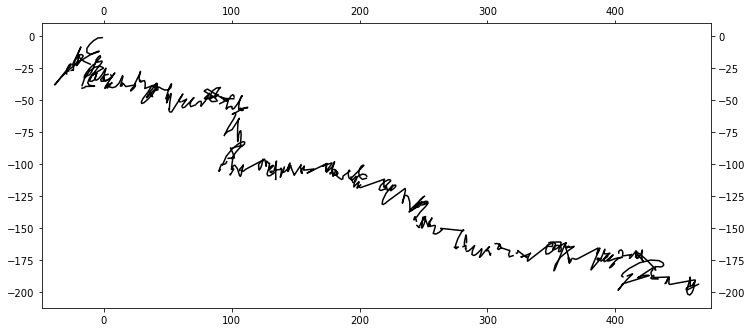

n_iter: 8050 of 15600, loss: -659.6115173339844, timeElapsed: 21486.764410972595
n_iter: 8100 of 15600, loss: -656.4871716308594, timeElapsed: 21619.601152658463
n_iter: 8150 of 15600, loss: -655.1826611328125, timeElapsed: 21753.216816186905
n_iter: 8200 of 15600, loss: -661.2948522949218, timeElapsed: 21886.046041727066


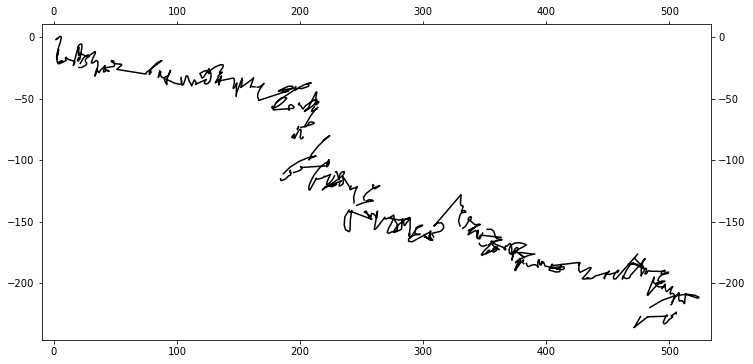

n_iter: 8250 of 15600, loss: -656.2632897949219, timeElapsed: 22018.859179496765
n_iter: 8300 of 15600, loss: -659.7320544433594, timeElapsed: 22152.092428207397
n_iter: 8350 of 15600, loss: -663.1284765625, timeElapsed: 22284.280029535294
n_iter: 8400 of 15600, loss: -663.2651623535156, timeElapsed: 22418.31577396393


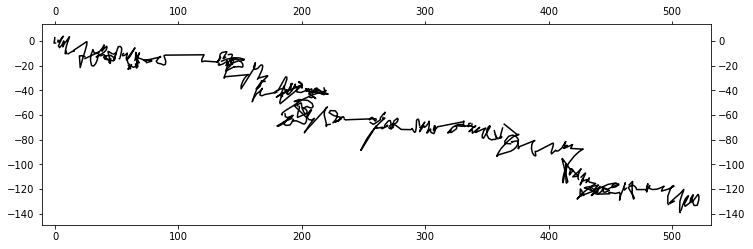

n_iter: 8450 of 15600, loss: -663.4710864257812, timeElapsed: 22552.97263455391
n_iter: 8500 of 15600, loss: -669.3211450195313, timeElapsed: 22685.882571697235
n_iter: 8550 of 15600, loss: -671.8410595703125, timeElapsed: 22819.24366903305
n_iter: 8600 of 15600, loss: -669.0409716796875, timeElapsed: 22952.807846307755


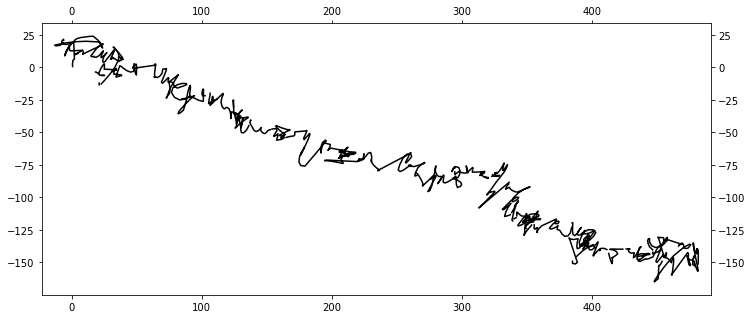

n_iter: 8650 of 15600, loss: -667.1517626953125, timeElapsed: 23087.30247068405
n_iter: 8700 of 15600, loss: -674.8812145996094, timeElapsed: 23220.357466459274
n_iter: 8750 of 15600, loss: -670.7765771484375, timeElapsed: 23353.360543251038
n_iter: 8800 of 15600, loss: -667.7330187988281, timeElapsed: 23485.836431980133


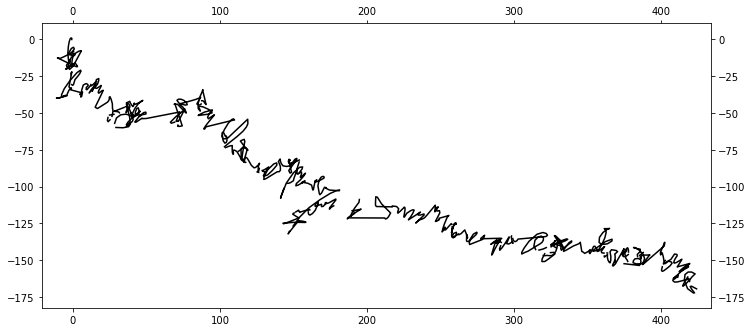

n_iter: 8850 of 15600, loss: -678.604111328125, timeElapsed: 23620.550679683685
n_iter: 8900 of 15600, loss: -683.3265979003907, timeElapsed: 23754.86971139908
n_iter: 8950 of 15600, loss: -682.1805810546875, timeElapsed: 23887.892104148865
n_iter: 9000 of 15600, loss: -674.2721728515625, timeElapsed: 24020.49017238617


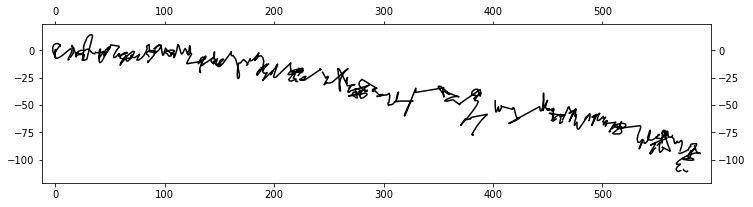

n_iter: 9050 of 15600, loss: -679.7863842773437, timeElapsed: 24154.90292263031
n_iter: 9100 of 15600, loss: -680.8224291992187, timeElapsed: 24288.24889731407
n_iter: 9150 of 15600, loss: -679.3796166992188, timeElapsed: 24421.246214151382
n_iter: 9200 of 15600, loss: -688.7129223632812, timeElapsed: 24554.893018960953


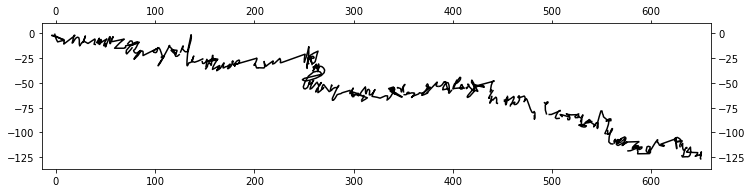

n_iter: 9250 of 15600, loss: -686.6167272949219, timeElapsed: 24689.805520534515
n_iter: 9300 of 15600, loss: -690.0374011230468, timeElapsed: 24822.54284286499
n_iter: 9350 of 15600, loss: -682.966904296875, timeElapsed: 24955.69932603836
n_iter: 9400 of 15600, loss: -686.3917419433594, timeElapsed: 25088.557404756546


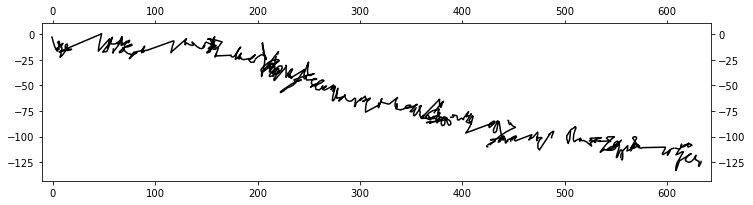

n_iter: 9450 of 15600, loss: -695.1738989257813, timeElapsed: 25224.72255706787
n_iter: 9500 of 15600, loss: -689.3597436523437, timeElapsed: 25357.489555120468
n_iter: 9550 of 15600, loss: -690.9083276367187, timeElapsed: 25491.070284843445
n_iter: 9600 of 15600, loss: -694.9851989746094, timeElapsed: 25623.519422769547


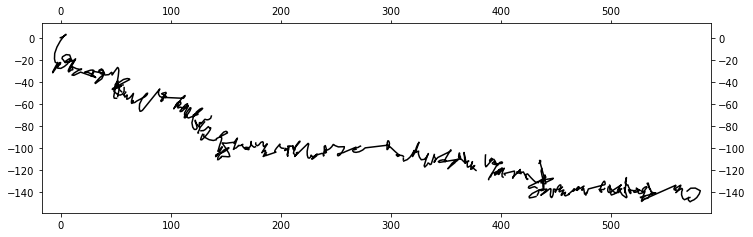

n_iter: 9650 of 15600, loss: -697.1093920898437, timeElapsed: 25757.862822294235
n_iter: 9700 of 15600, loss: -691.7226049804688, timeElapsed: 25891.180029153824
n_iter: 9750 of 15600, loss: -696.0217370605469, timeElapsed: 26024.031538963318
n_iter: 9800 of 15600, loss: -697.0247412109375, timeElapsed: 26156.31614470482


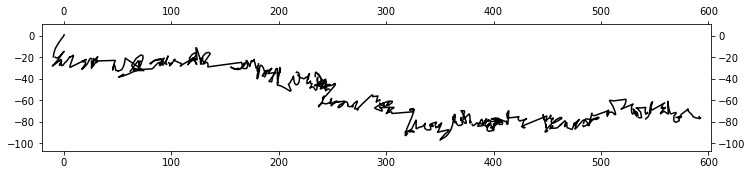

n_iter: 9850 of 15600, loss: -701.0000256347656, timeElapsed: 26291.157503843307
n_iter: 9900 of 15600, loss: -699.4793676757813, timeElapsed: 26424.757744550705
n_iter: 9950 of 15600, loss: -703.7403283691406, timeElapsed: 26558.035399198532
n_iter: 10000 of 15600, loss: -696.9732885742187, timeElapsed: 26690.333915948868


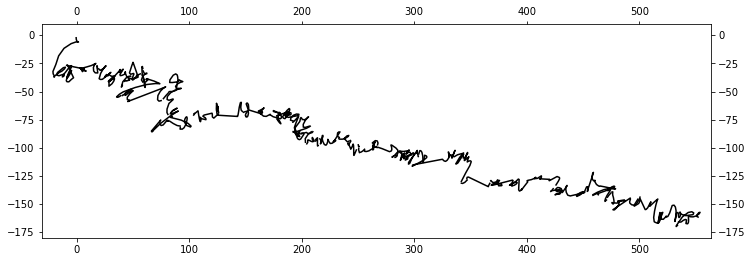

n_iter: 10050 of 15600, loss: -705.0088159179687, timeElapsed: 26825.106001853943
n_iter: 10100 of 15600, loss: -708.1202734375, timeElapsed: 26958.22043776512
n_iter: 10150 of 15600, loss: -700.6251940917969, timeElapsed: 27091.313220739365
n_iter: 10200 of 15600, loss: -705.3758447265625, timeElapsed: 27224.41975402832


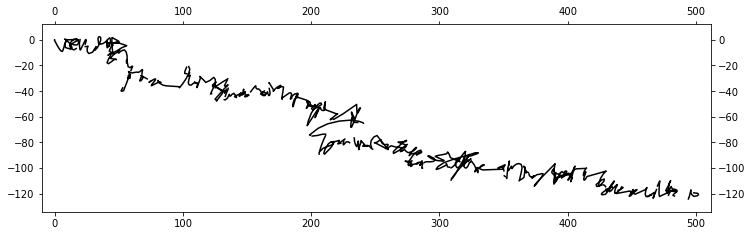

n_iter: 10250 of 15600, loss: -709.7167297363281, timeElapsed: 27359.70178961754
n_iter: 10300 of 15600, loss: -706.6996508789063, timeElapsed: 27492.925506830215
n_iter: 10350 of 15600, loss: -708.5057385253906, timeElapsed: 27626.546607255936
n_iter: 10400 of 15600, loss: -707.4573388671874, timeElapsed: 27759.23080086708


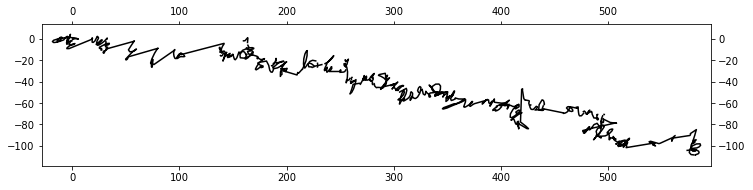

n_iter: 10450 of 15600, loss: -718.1588317871094, timeElapsed: 27894.600319862366
n_iter: 10500 of 15600, loss: -717.6007360839844, timeElapsed: 28028.616716623306
n_iter: 10550 of 15600, loss: -708.130224609375, timeElapsed: 28161.688101530075
n_iter: 10600 of 15600, loss: -712.7292126464844, timeElapsed: 28294.455621242523


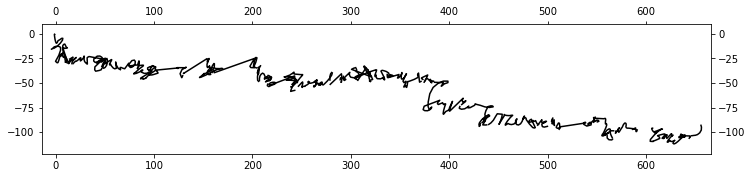

n_iter: 10650 of 15600, loss: -720.2738977050781, timeElapsed: 28429.265616178513
n_iter: 10700 of 15600, loss: -715.6935070800781, timeElapsed: 28561.184065818787
n_iter: 10750 of 15600, loss: -719.7116772460937, timeElapsed: 28693.90170621872
n_iter: 10800 of 15600, loss: -717.66265625, timeElapsed: 28827.433029651642


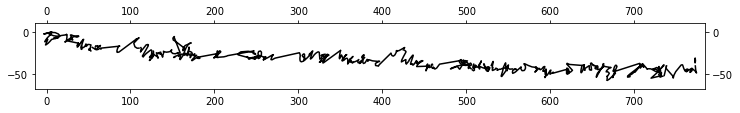

n_iter: 10850 of 15600, loss: -722.3368078613281, timeElapsed: 28962.322529554367
n_iter: 10900 of 15600, loss: -725.6607885742187, timeElapsed: 29095.5145676136
n_iter: 10950 of 15600, loss: -717.6376745605469, timeElapsed: 29228.26167321205
n_iter: 11000 of 15600, loss: -722.7760168457031, timeElapsed: 29361.109842538834


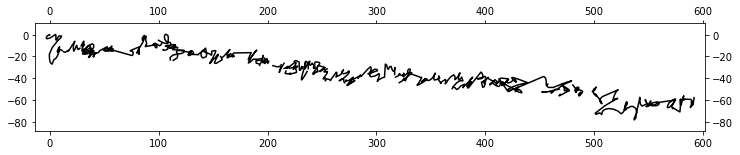

n_iter: 11050 of 15600, loss: -721.1700390625, timeElapsed: 29495.253009319305
n_iter: 11100 of 15600, loss: -727.220400390625, timeElapsed: 29628.645026922226
n_iter: 11150 of 15600, loss: -722.8718334960937, timeElapsed: 29761.491478443146
n_iter: 11200 of 15600, loss: -734.1397583007813, timeElapsed: 29895.364919662476


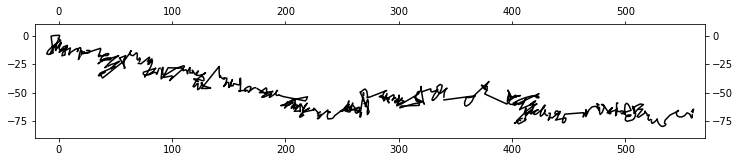

n_iter: 11250 of 15600, loss: -726.7238818359375, timeElapsed: 30030.04918718338
n_iter: 11300 of 15600, loss: -727.6569934082031, timeElapsed: 30162.48261833191
n_iter: 11350 of 15600, loss: -729.021650390625, timeElapsed: 30295.88395667076
n_iter: 11400 of 15600, loss: -734.9823425292968, timeElapsed: 30427.8952190876


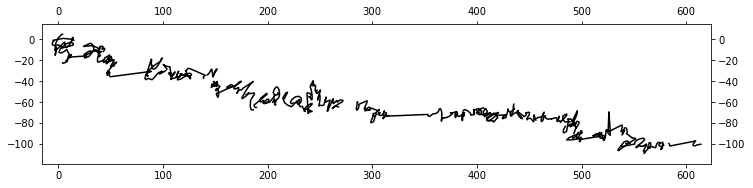

n_iter: 11450 of 15600, loss: -730.0724682617188, timeElapsed: 30563.220059871674
n_iter: 11500 of 15600, loss: -729.3757666015625, timeElapsed: 30696.418443918228
n_iter: 11550 of 15600, loss: -740.6560070800781, timeElapsed: 30828.540615081787
n_iter: 11600 of 15600, loss: -730.6824841308594, timeElapsed: 30961.77485179901


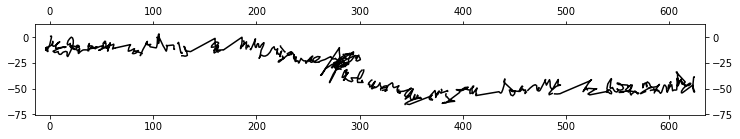

n_iter: 11650 of 15600, loss: -742.6237182617188, timeElapsed: 31096.690275907516
n_iter: 11700 of 15600, loss: -736.67666015625, timeElapsed: 31229.562751054764
n_iter: 11750 of 15600, loss: -733.7722253417969, timeElapsed: 31361.452256441116
n_iter: 11800 of 15600, loss: -743.8952124023438, timeElapsed: 31494.15198659897


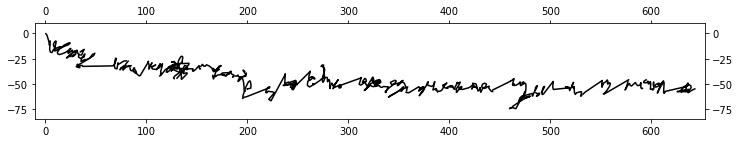

n_iter: 11850 of 15600, loss: -737.1996142578125, timeElapsed: 31628.882405519485
n_iter: 11900 of 15600, loss: -746.3529699707032, timeElapsed: 31762.290103197098
n_iter: 11950 of 15600, loss: -737.375224609375, timeElapsed: 31895.068236112595
n_iter: 12000 of 15600, loss: -745.1746118164062, timeElapsed: 32028.411698818207


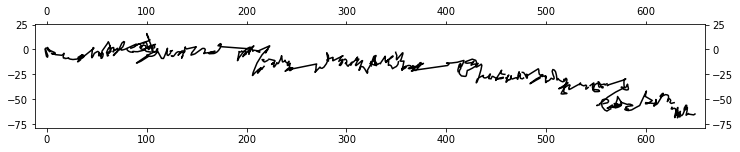

n_iter: 12050 of 15600, loss: -745.1788439941406, timeElapsed: 32164.06447148323
n_iter: 12100 of 15600, loss: -742.5088000488281, timeElapsed: 32297.51354455948
n_iter: 12150 of 15600, loss: -745.5620593261718, timeElapsed: 32430.40290927887
n_iter: 12200 of 15600, loss: -749.9306530761719, timeElapsed: 32564.550799131393


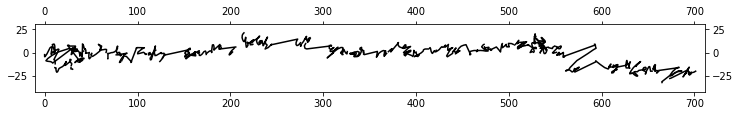

n_iter: 12250 of 15600, loss: -747.6090893554688, timeElapsed: 32699.74968147278
n_iter: 12300 of 15600, loss: -752.697734375, timeElapsed: 32832.72341108322
n_iter: 12350 of 15600, loss: -743.5676403808594, timeElapsed: 32964.64189863205
n_iter: 12400 of 15600, loss: -753.535185546875, timeElapsed: 33096.77864766121


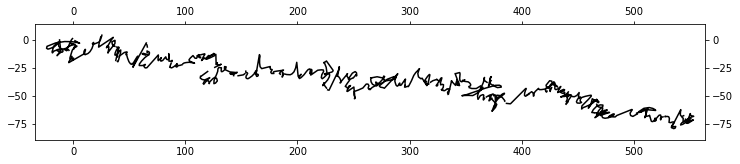

n_iter: 12450 of 15600, loss: -753.6343737792969, timeElapsed: 33232.03645205498
n_iter: 12500 of 15600, loss: -747.7520324707032, timeElapsed: 33364.38889336586
n_iter: 12550 of 15600, loss: -757.8222338867188, timeElapsed: 33497.17727470398
n_iter: 12600 of 15600, loss: -760.1182421875, timeElapsed: 33629.42237138748


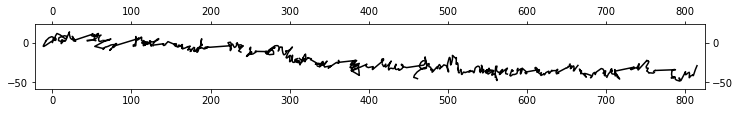

n_iter: 12650 of 15600, loss: -751.4408557128907, timeElapsed: 33763.65503501892
n_iter: 12700 of 15600, loss: -754.0443664550781, timeElapsed: 33896.396846055984
n_iter: 12750 of 15600, loss: -756.3343933105468, timeElapsed: 34028.86961579323
n_iter: 12800 of 15600, loss: -762.3450183105468, timeElapsed: 34161.79457974434


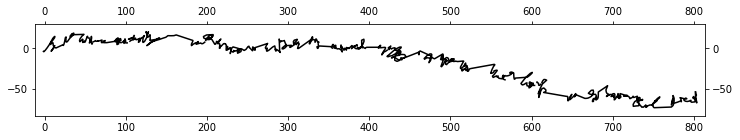

n_iter: 12850 of 15600, loss: -756.5337231445312, timeElapsed: 34297.21785759926
n_iter: 12900 of 15600, loss: -757.9402160644531, timeElapsed: 34430.584154605865
n_iter: 12950 of 15600, loss: -767.0890588378907, timeElapsed: 34564.41576600075
n_iter: 13000 of 15600, loss: -762.5239013671875, timeElapsed: 34697.33584213257


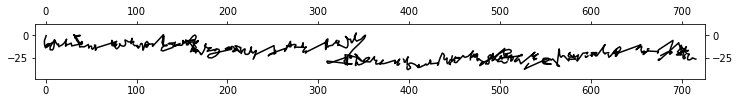

n_iter: 13050 of 15600, loss: -753.2599743652344, timeElapsed: 34832.1136162281
n_iter: 13100 of 15600, loss: -771.9738610839844, timeElapsed: 34964.7075548172
n_iter: 13150 of 15600, loss: -759.1919580078124, timeElapsed: 35096.76247429848
n_iter: 13200 of 15600, loss: -764.2787414550781, timeElapsed: 35229.11877679825


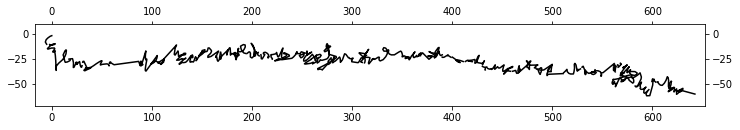

n_iter: 13250 of 15600, loss: -769.5177502441406, timeElapsed: 35363.34383106232
n_iter: 13300 of 15600, loss: -770.1902282714843, timeElapsed: 35497.21835947037
n_iter: 13350 of 15600, loss: -769.2387841796875, timeElapsed: 35630.397428274155
n_iter: 13400 of 15600, loss: -766.8404223632813, timeElapsed: 35763.776317596436


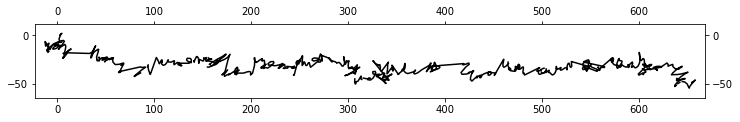

n_iter: 13450 of 15600, loss: -772.9857922363282, timeElapsed: 35899.70546889305
n_iter: 13500 of 15600, loss: -768.0155285644531, timeElapsed: 36032.78440785408
n_iter: 13550 of 15600, loss: -771.0435485839844, timeElapsed: 36166.1626727581
n_iter: 13600 of 15600, loss: -776.694033203125, timeElapsed: 36298.9178879261


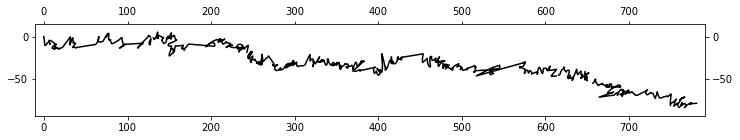

n_iter: 13650 of 15600, loss: -770.180849609375, timeElapsed: 36433.43630385399
n_iter: 13700 of 15600, loss: -774.0883325195313, timeElapsed: 36566.02863049507
n_iter: 13750 of 15600, loss: -772.6119555664062, timeElapsed: 36699.856546640396
n_iter: 13800 of 15600, loss: -783.1149963378906, timeElapsed: 36834.61526250839


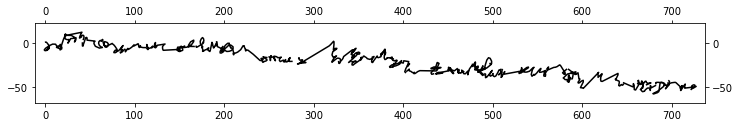

n_iter: 13850 of 15600, loss: -771.2129968261719, timeElapsed: 36969.26555395126
n_iter: 13900 of 15600, loss: -785.2719201660157, timeElapsed: 37102.351274728775
n_iter: 13950 of 15600, loss: -774.1929455566407, timeElapsed: 37235.49381661415
n_iter: 14000 of 15600, loss: -779.1143688964844, timeElapsed: 37369.140169620514


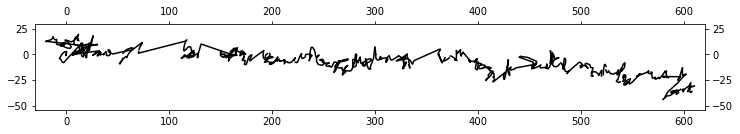

n_iter: 14050 of 15600, loss: -779.6421887207031, timeElapsed: 37504.31841492653
n_iter: 14100 of 15600, loss: -780.2695715332031, timeElapsed: 37637.23979759216
n_iter: 14150 of 15600, loss: -781.6407006835938, timeElapsed: 37770.48734378815
n_iter: 14200 of 15600, loss: -781.7756359863281, timeElapsed: 37903.93001008034


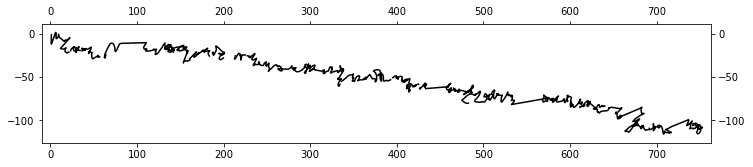

n_iter: 14250 of 15600, loss: -787.5483435058594, timeElapsed: 38038.94016623497
n_iter: 14300 of 15600, loss: -777.4897473144531, timeElapsed: 38171.43266224861
n_iter: 14350 of 15600, loss: -790.4010888671875, timeElapsed: 38304.88228058815
n_iter: 14400 of 15600, loss: -782.2155187988282, timeElapsed: 38437.709615945816


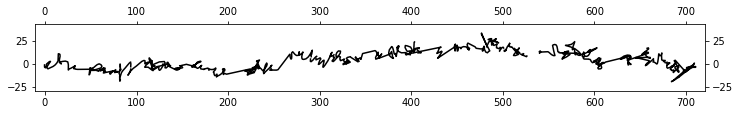

n_iter: 14450 of 15600, loss: -793.6364501953125, timeElapsed: 38572.40585565567
n_iter: 14500 of 15600, loss: -786.6354711914063, timeElapsed: 38705.566700696945
n_iter: 14550 of 15600, loss: -786.9135119628907, timeElapsed: 38837.81293439865
n_iter: 14600 of 15600, loss: -794.2575854492187, timeElapsed: 38971.43052482605


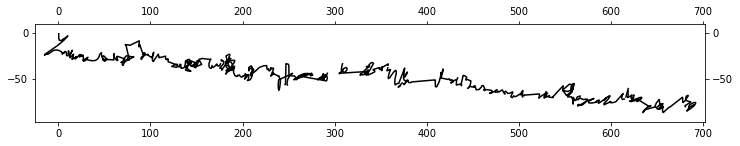

n_iter: 14650 of 15600, loss: -780.945810546875, timeElapsed: 39106.30654382706
n_iter: 14700 of 15600, loss: -799.6621179199219, timeElapsed: 39239.13041186333
n_iter: 14750 of 15600, loss: -787.7309875488281, timeElapsed: 39371.2601647377
n_iter: 14800 of 15600, loss: -790.9328161621094, timeElapsed: 39503.50421857834


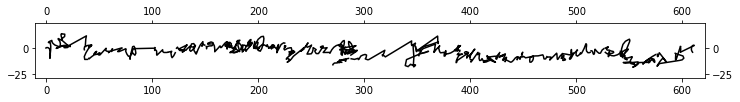

n_iter: 14850 of 15600, loss: -793.6622082519531, timeElapsed: 39639.06037425995
n_iter: 14900 of 15600, loss: -800.7241027832031, timeElapsed: 39772.00455021858
n_iter: 14950 of 15600, loss: -789.571220703125, timeElapsed: 39905.016949892044
n_iter: 15000 of 15600, loss: -799.5325354003907, timeElapsed: 40037.67081737518


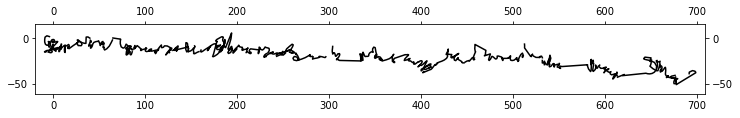

n_iter: 15050 of 15600, loss: -799.1730810546875, timeElapsed: 40171.7812731266
n_iter: 15100 of 15600, loss: -791.4983959960938, timeElapsed: 40304.39608860016
n_iter: 15150 of 15600, loss: -803.7453576660156, timeElapsed: 40438.584196567535
n_iter: 15200 of 15600, loss: -796.8052453613282, timeElapsed: 40571.44114613533


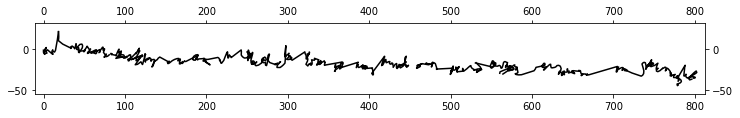

n_iter: 15250 of 15600, loss: -799.0997351074219, timeElapsed: 40706.50680708885
n_iter: 15300 of 15600, loss: -798.1747241210937, timeElapsed: 40839.455479860306
n_iter: 15350 of 15600, loss: -801.1136694335937, timeElapsed: 40972.003400325775
n_iter: 15400 of 15600, loss: -808.7915771484375, timeElapsed: 41104.26280665398


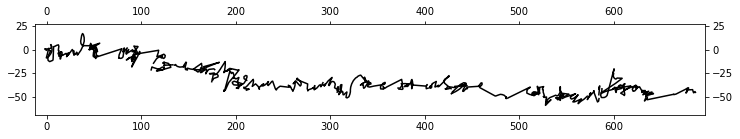

n_iter: 15450 of 15600, loss: -801.532275390625, timeElapsed: 41239.29137158394
n_iter: 15500 of 15600, loss: -802.965673828125, timeElapsed: 41372.49057817459
n_iter: 15550 of 15600, loss: -803.0961462402344, timeElapsed: 41505.67917108536


<Figure size 432x288 with 0 Axes>

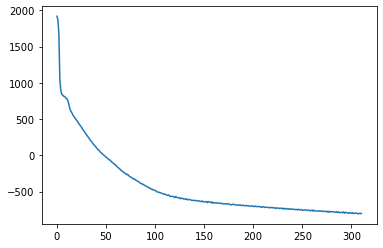

In [9]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, inputs, lengths, h0, c0):
        packed_x = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out1, _ = self.lstm1(packed_x, (h0, c0))
        out1, _ = pad_packed_sequence(packed_out1, batch_first=True)
        inputs = inputs[:, :out1.shape[1], :]
        packed_inp2 = pack_padded_sequence(
            torch.cat((inputs, out1), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out2, _ = self.lstm2(packed_inp2, (h0, c0))
        out2, _ = pad_packed_sequence(packed_out2, batch_first=True)

        packed_inp3 = pack_padded_sequence(
            torch.cat((inputs, out2), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out3, _ = self.lstm3(packed_inp3, (h0, c0))
        out3, _ = pad_packed_sequence(packed_out3, batch_first=True)

        input4 = torch.cat((out1, out2, out3), -1)
        out4 = self.linear(input4)
        return out4, (out1, out2, out3)

input_size = 3
hidden_size = 500
batch_size = 128
n_mixtures = 20
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

# def negative_log_likelihood(batch_params, stroke_lengths, batch_targets, batch_mask):  
#     batch_size = batch_params.shape[0]

#     es = 1/(1 + torch.exp(batch_params[:,:,-1]))
#     pis = nn.Softmax(2)(batch_params[:,:,0:n_mixtures])
#     mus = batch_params[:, :, n_mixtures:3*n_mixtures].reshape(batch_size, -1, n_mixtures, 2)
#     sigmas = torch.exp(batch_params[:,:, 3*n_mixtures:5*n_mixtures].reshape(batch_size, -1, n_mixtures, 2))
#     phos = torch.tanh(batch_params[:,:, 5*n_mixtures:6*n_mixtures].reshape(batch_size, -1, n_mixtures, 1))

#     covs = torch.zeros(batch_params.shape[0],
#                        batch_params.shape[1],
#                        n_mixtures, 2, 2, device=device)
#     covs[:,:,:,0,0] = sigmas[:,:,:,0] ** 2
#     covs[:,:,:,0,1] = sigmas[:,:,:,0] * sigmas[:,:,:,1] * phos[:,:,:,0]
#     covs[:,:,:,1,0] = covs[:,:,:,0,1]
#     covs[:,:,:,1,1] = sigmas[:,:,:,1] ** 2

#     distributions = torch.distributions.MultivariateNormal(mus, covs)

#     target_coords = batch_targets[:,:,0:2].unsqueeze(2).repeat_interleave(
#         torch.tensor([n_mixtures], device=device), dim=2)
#     stroke_lift = batch_targets[:,:,-1]

#     probs = torch.exp(distributions.log_prob(target_coords))
#     loss_per_coord = - torch.logsumexp(torch.log(pis) + probs, dim=2)  - torch.log(es)*stroke_lift - torch.log(1 - es)*(1-stroke_lift)
#     batch_loss = (loss_per_coord * batch_mask).sum()
#     return batch_loss/batch_size

def negative_log_likelihood(batch_params, stroke_lengths, batch_targets, batch_mask):  
    batch_loss = 0
    for i in range(len(stroke_lengths)):
        stroke_length = stroke_lengths[i]
        params = batch_params[i][:stroke_length-1]
        targets = batch_targets[i][1:stroke_length]
        
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,:,0,0] = sigmas[:,:,0] ** 2
        covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,:,1,0] = covs[:,:,0,1]
        covs[:,:,1,1] = sigmas[:,:,1] ** 2


        distributions = torch.distributions.MultivariateNormal(mus, covs)

        target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
        stroke_lift = targets[:,-1]

        probs = torch.exp(distributions.log_prob(target_coords))
        #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
        probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
    #     print(torch.log((pis*probs).sum(dim=1)).sum())
    #     print((torch.log(es)*stroke_lift).sum())
    #     print((torch.log(1 - es)*(1-stroke_lift)).sum())

        batch_loss += - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(batch_loss/len(stroke_lengths))
    return batch_loss/len(stroke_lengths)

def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)
            
            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            input4 = torch.cat((out1, out2, out3), -1)
            params = m.linear(input4)[0]

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off
            
        predictions[1:, 0:2] *= torch.tensor(std, device=device)
        predictions[1:, 0:2] += torch.tensor(means, device=device)

    draw(predictions.cpu(), plot_end_points=False)
    plt.show()

def train(model, input_strokes, stroke_lengths, input_mask, optimizer, h0, c0):
    optimizer.zero_grad()
    
    # prepare for packing
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    strokes_sorted_by_length = input_strokes[perm_idx]
    input_mask_sorted_by_length = input_mask[perm_idx]

    outputs, _ = model(strokes_sorted_by_length, stroke_lengths_sorted - 1 , h0, c0)

    loss = negative_log_likelihood(
        outputs,
        stroke_lengths_sorted - 1, # We only have T-1 LSTM cells so we need to measure loss on only T-1 units
        strokes_sorted_by_length[:, 1:outputs.shape[1]+1], # We want to offset by 1 as the targets are the predictions for the next data point
        input_mask_sorted_by_length[:, 1:outputs.shape[1]+1]
    )
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 10)
    torch.nn.utils.clip_grad_value_(loss, 100)
    # torch.clamp_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 50
n_epochs = 200
draw_every = 200
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

h0=torch.zeros(1, batch_size, hidden_size, device=device)
c0=torch.zeros(1, batch_size, hidden_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens, mask in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens.to(device),
            input_mask=mask.to(device),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/prediction_logsumexp_std_vctnll_clamped.pt")

        if n_iters % draw_every == 0:
            sample_drawing()
            
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 15600 of 15600, loss: -807.1935046386719, timeElapsed: 41638.441836595535


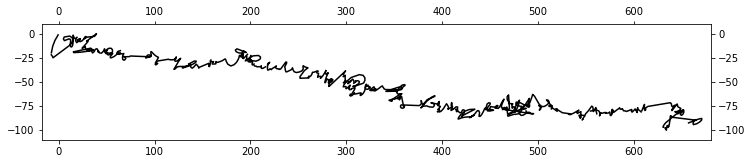

n_iter: 15650 of 15600, loss: -807.4947192382813, timeElapsed: 41772.6411781311
n_iter: 15700 of 15600, loss: -807.32541015625, timeElapsed: 41906.462485313416
n_iter: 15750 of 15600, loss: -807.3741052246094, timeElapsed: 42039.16678118706
n_iter: 15800 of 15600, loss: -811.4669604492187, timeElapsed: 42172.77354192734


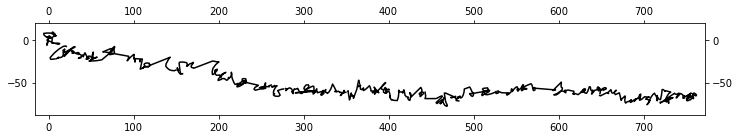

n_iter: 15850 of 15600, loss: -803.2790759277344, timeElapsed: 42306.99098587036
n_iter: 15900 of 15600, loss: -814.3901159667969, timeElapsed: 42440.70944571495
n_iter: 15950 of 15600, loss: -802.2565478515625, timeElapsed: 42573.541934251785
n_iter: 16000 of 15600, loss: -813.4331884765625, timeElapsed: 42706.47053480148


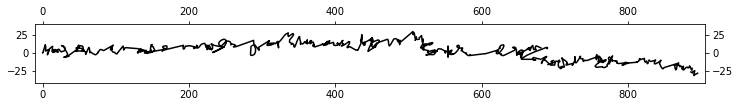

n_iter: 16050 of 15600, loss: -811.1935107421875, timeElapsed: 42840.81482243538
n_iter: 16100 of 15600, loss: -817.6239831542969, timeElapsed: 42974.166177511215
n_iter: 16150 of 15600, loss: -815.0676037597656, timeElapsed: 43106.94090747833
n_iter: 16200 of 15600, loss: -815.4116271972656, timeElapsed: 43239.974304676056


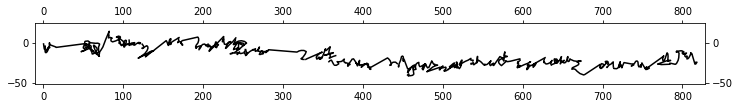

n_iter: 16250 of 15600, loss: -812.4595532226563, timeElapsed: 43373.97892332077
n_iter: 16300 of 15600, loss: -814.5378930664062, timeElapsed: 43506.888419151306
n_iter: 16350 of 15600, loss: -819.9175952148438, timeElapsed: 43638.58825969696


In [ ]:

for i in range(n_epochs):
    for strokes, stroke_lens, mask in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens.to(device),
            input_mask=mask.to(device),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/prediction_logsumexp_std_vctnll_clamped.pt")

        if n_iters % draw_every == 0:
            sample_drawing()
            
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [ ]:
for i in range(n_epochs):
    for strokes, stroke_lens, mask in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens.to(device),
            input_mask=mask.to(device),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/prediction_logsumexp_std_vctnll_2.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [10]:
def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)
            
            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            input4 = torch.cat((out1, out2, out3), -1)
            params = m.linear(input4)[0]

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off

        predictions[1:, 0:2] *= torch.tensor(std, device=device)
        predictions[1:, 0:2] += torch.tensor(means, device=device)

    drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)


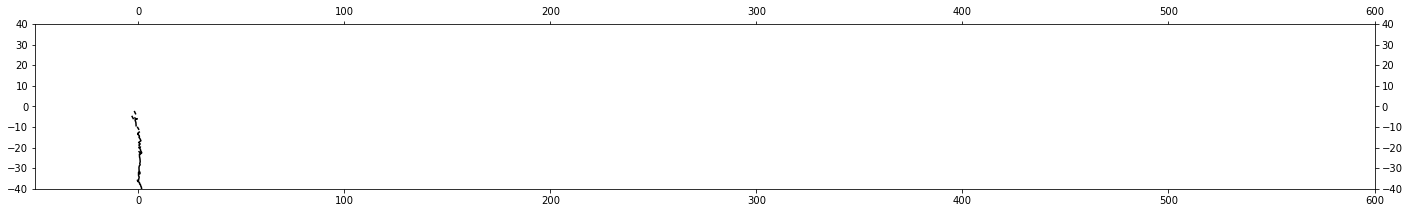

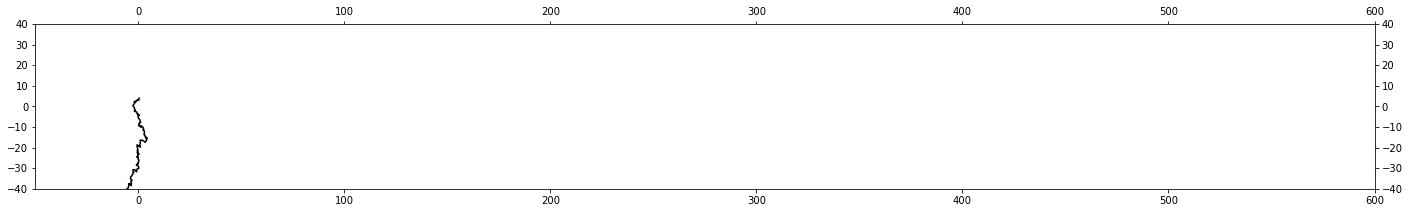

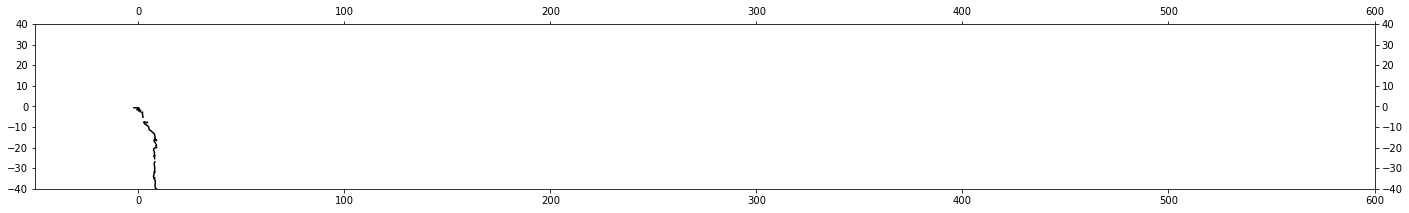

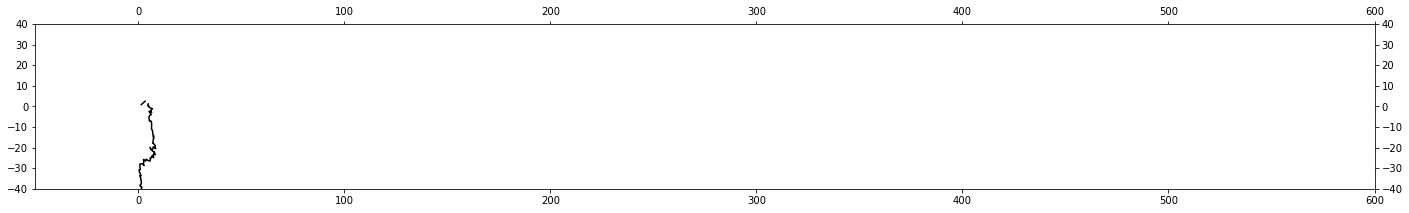

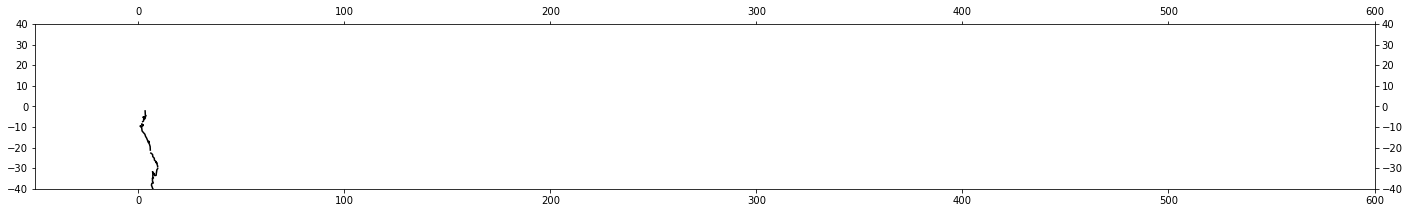

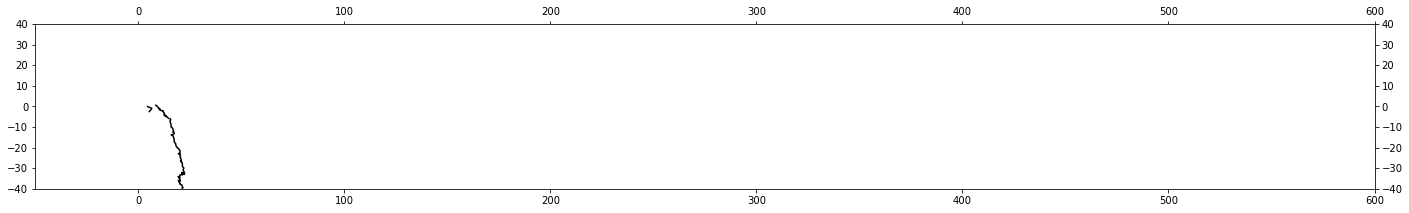

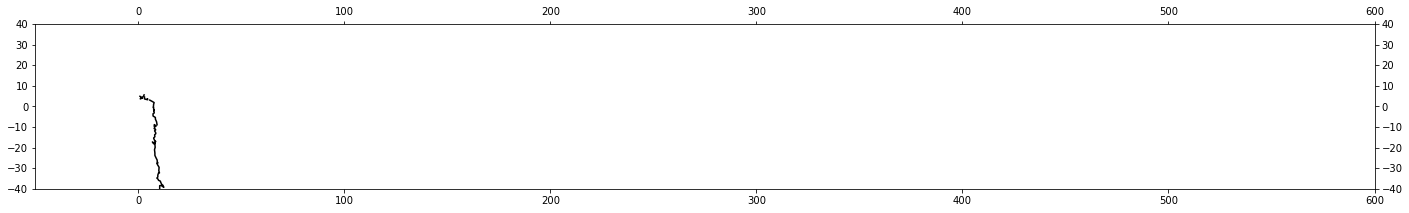

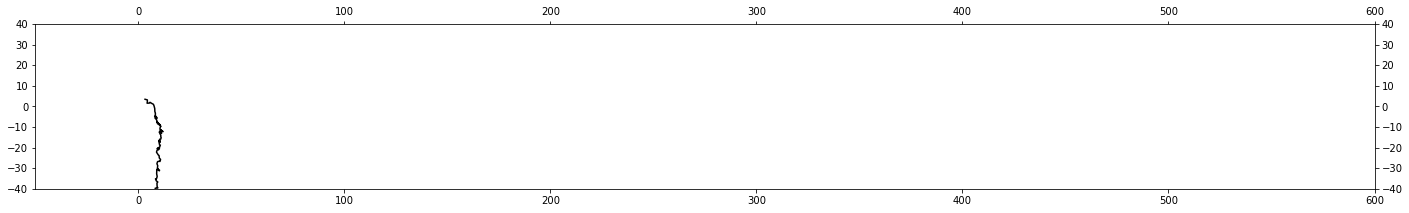

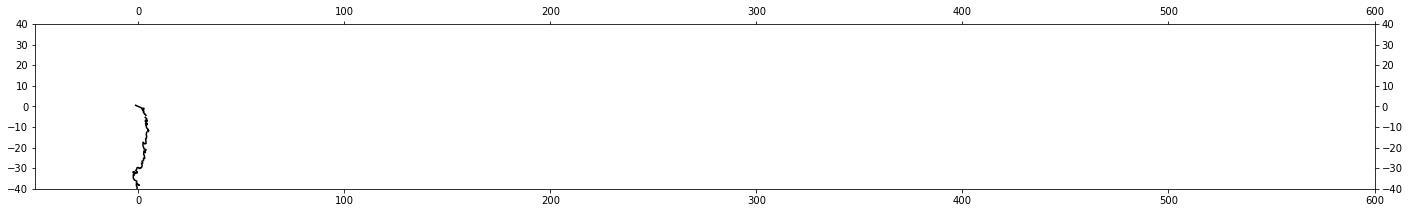

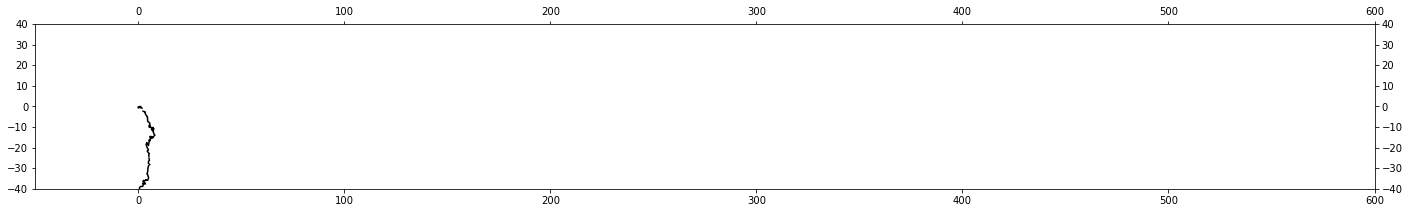

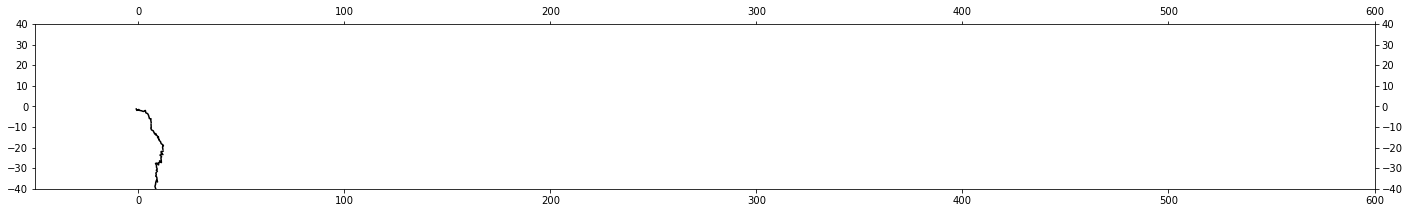

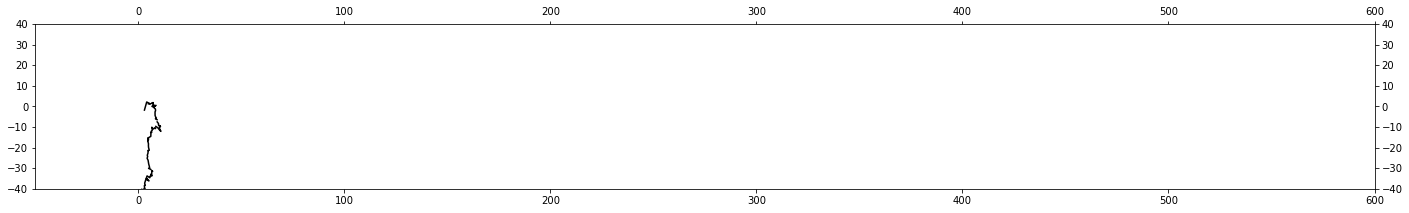

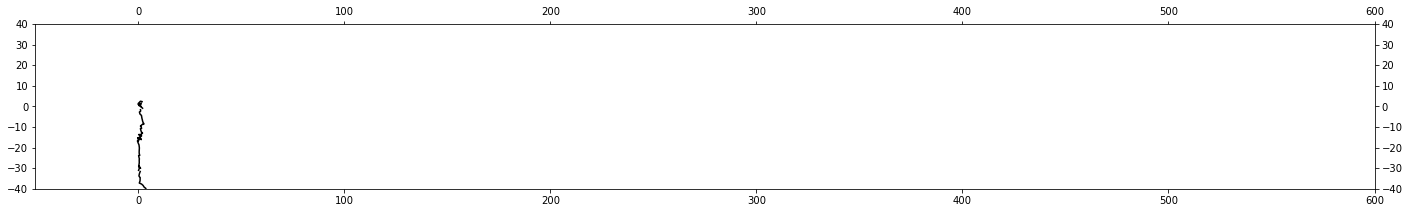

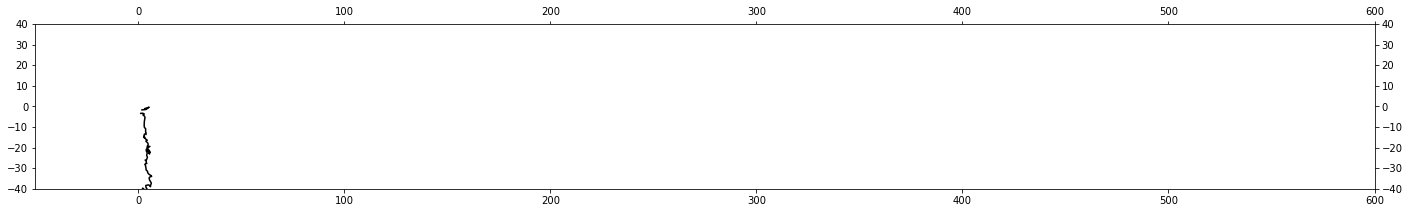

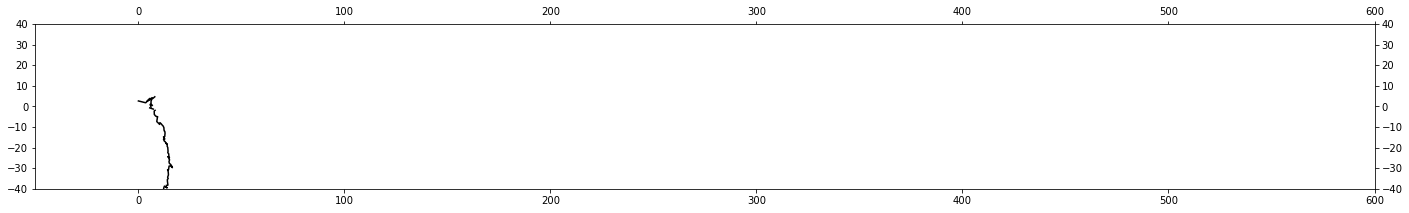

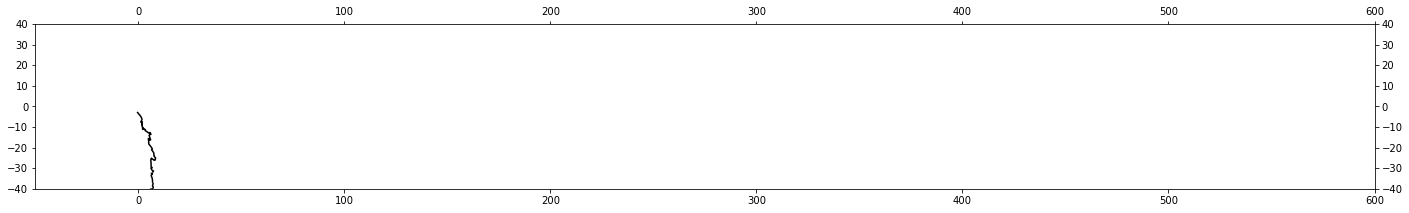

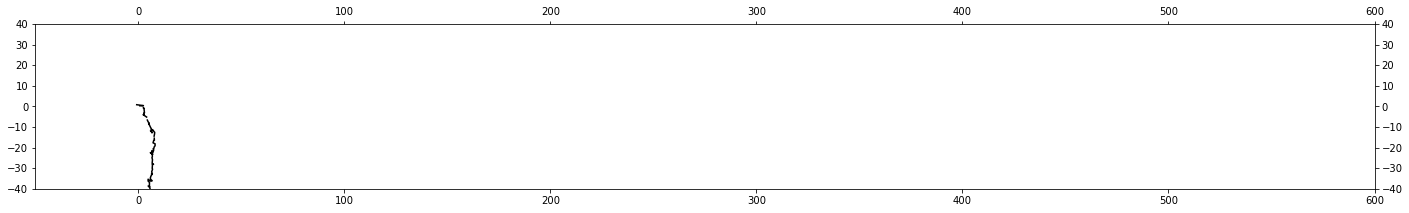

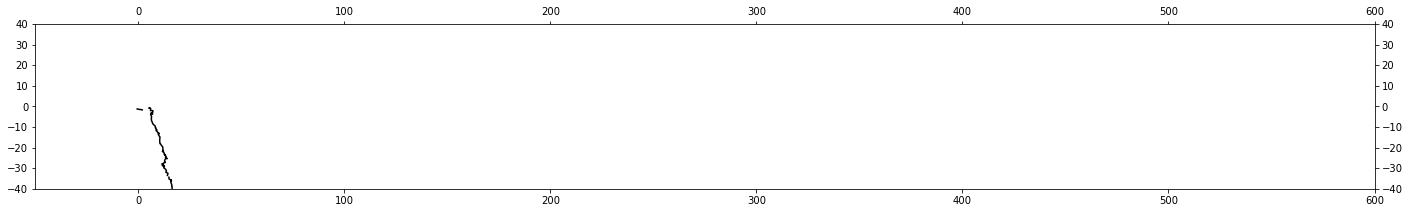

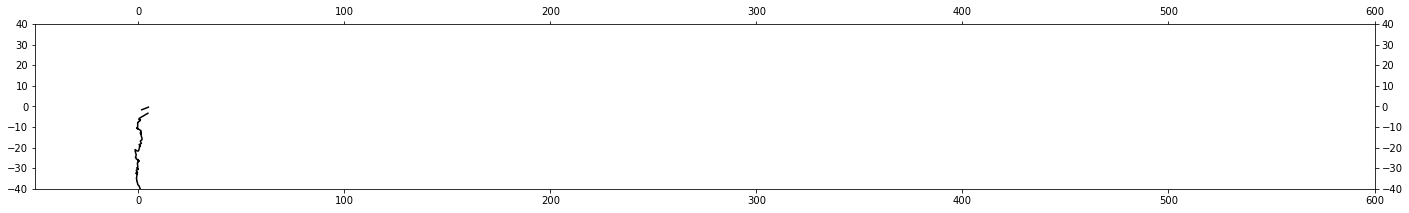

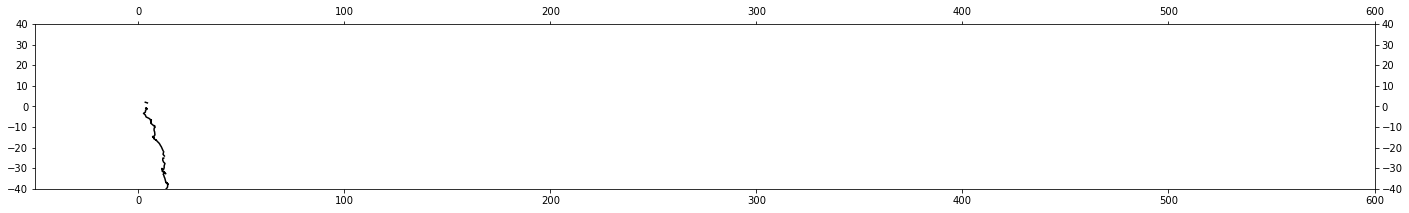

In [11]:
for i in range(20):
    sample_drawing()

n_iter: 22500 of 4375, loss: -864.3271037597656, timeElapsed: 146.87345504760742
n_iter: 23000 of 4375, loss: -874.6805788574219, timeElapsed: 326.18258452415466
n_iter: 23500 of 4375, loss: -876.6286329345703, timeElapsed: 505.77893924713135
n_iter: 24000 of 4375, loss: -879.0949903564454, timeElapsed: 685.5430738925934
n_iter: 24500 of 4375, loss: -887.3768635253906, timeElapsed: 865.1040363311768
n_iter: 25000 of 4375, loss: -884.179810546875, timeElapsed: 1044.1250612735748
n_iter: 25500 of 4375, loss: -897.1061680908203, timeElapsed: 1224.0299060344696


<Figure size 432x288 with 0 Axes>

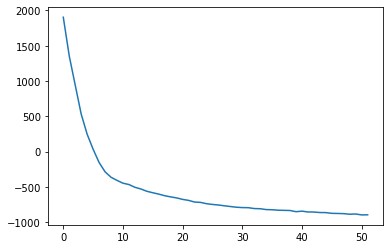

In [52]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

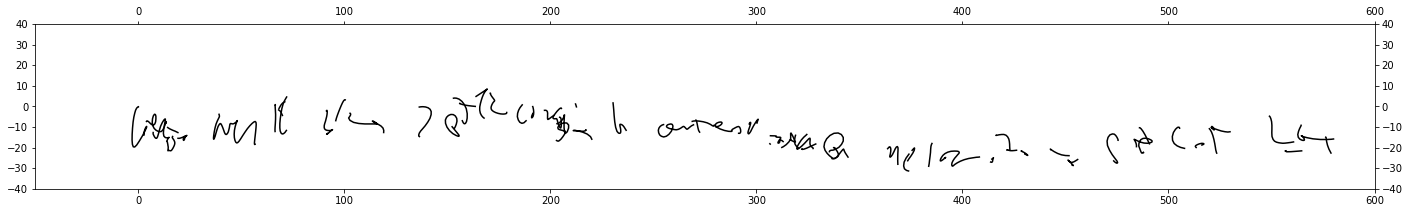

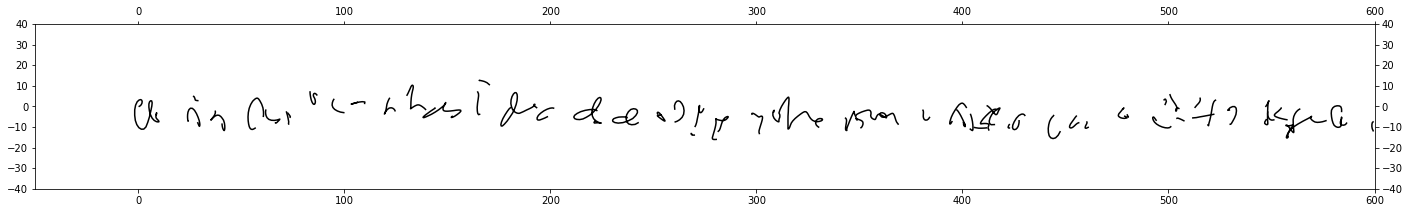

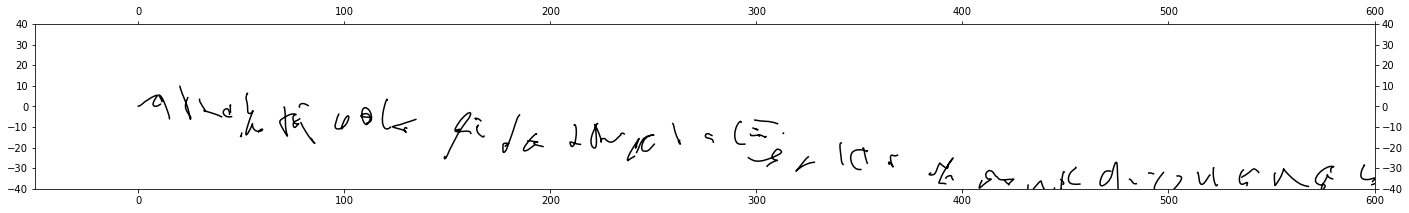

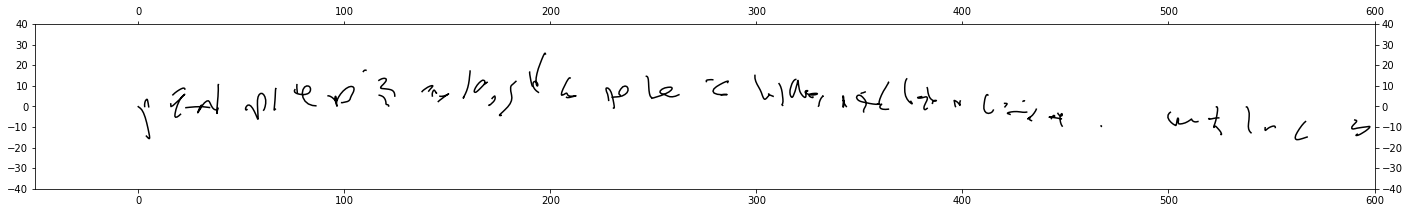

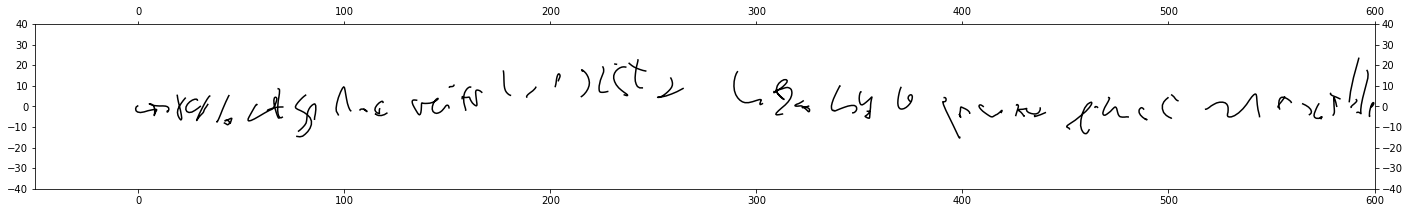

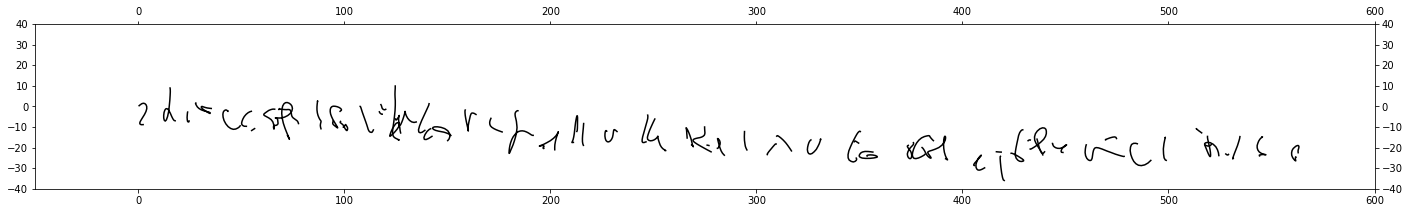

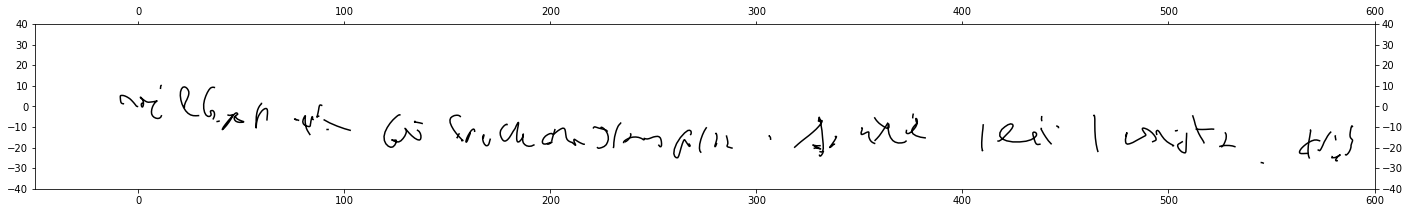

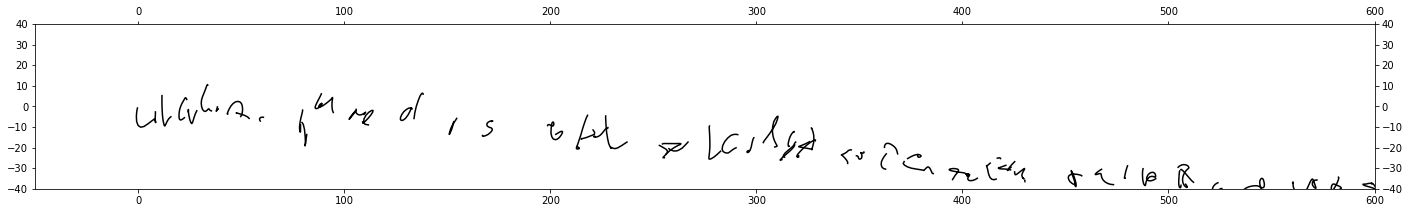

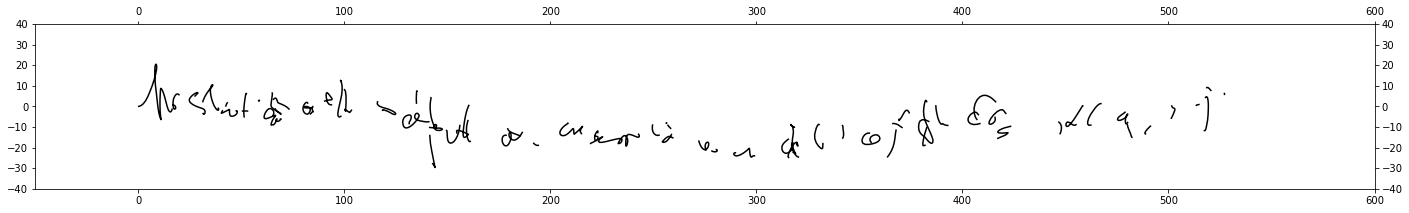

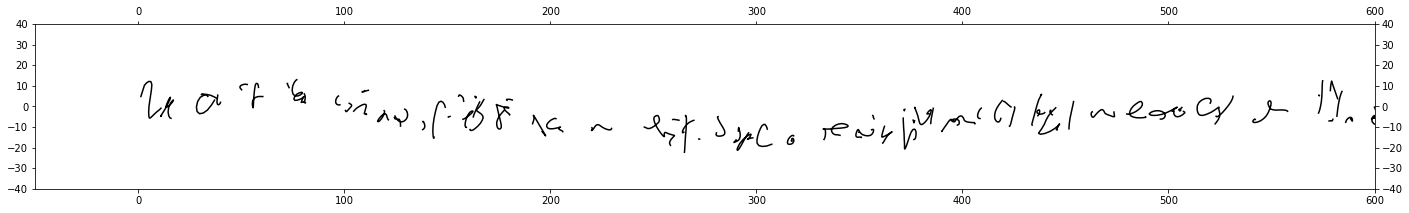

In [53]:
for i in range(10):
    sample_drawing()

n_iter: 0 of 30000, loss: 3.847310302734375, timeElapsed: 0.11220240592956543
n_iter: 500 of 30000, loss: 2004.0821067504883, timeElapsed: 60.391905069351196
n_iter: 1000 of 30000, loss: 1652.998860687256, timeElapsed: 122.22360348701477
n_iter: 1500 of 30000, loss: 1504.8780248413086, timeElapsed: 184.556307554245
n_iter: 2000 of 30000, loss: 1349.756440460205, timeElapsed: 246.48905515670776
n_iter: 2500 of 30000, loss: 1169.17427444458, timeElapsed: 307.89942812919617
n_iter: 3000 of 30000, loss: 1012.6606830291748, timeElapsed: 371.02262020111084
n_iter: 3500 of 30000, loss: 702.095825471878, timeElapsed: 433.24610209465027
n_iter: 4000 of 30000, loss: 546.4414993247985, timeElapsed: 494.79349422454834
n_iter: 4500 of 30000, loss: 436.102669342041, timeElapsed: 556.7463657855988
n_iter: 5000 of 30000, loss: 251.99758296775818, timeElapsed: 618.2831344604492
n_iter: 5500 of 30000, loss: 188.47319030380248, timeElapsed: 679.9425678253174
n_iter: 6000 of 30000, loss: 194.1795405044555

<Figure size 432x288 with 0 Axes>

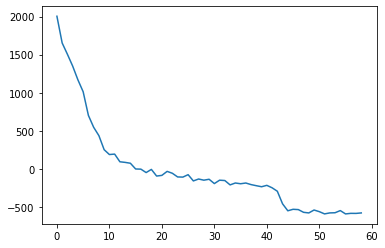

In [23]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4

input_size = 3
hidden_size = 500
batch_size = 1
n_mixtures = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(params, stroke_length, targets=None):   
    #print(params)
    es = 1/(1 + torch.exp(params[:,-1]))
    pis = nn.Softmax(1)(params[:,0:n_mixtures])
    mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
    phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

    covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
    tol = torch.tensor(0.000000001, device=device)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
        torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    probs = torch.exp(distributions.log_prob(target_coords))
    #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
#     print(torch.log((pis*probs).sum(dim=1)).sum())
#     print((torch.log(es)*stroke_lift).sum())
#     print((torch.log(1 - es)*(1-stroke_lift)).sum())

    loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(loss)
    return loss


def train(model, input_stroke, stroke_len, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0)
    loss = negative_log_likelihood(out, stroke_len, input_stroke[:,1:stroke_len,:].squeeze())
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 3
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model2.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

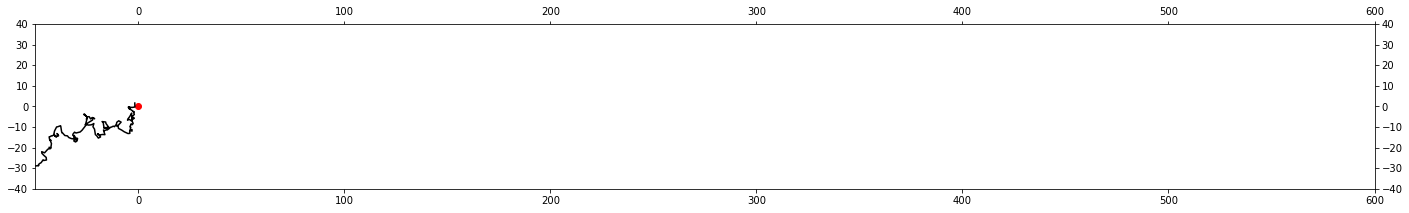

In [53]:
timestamps = 1200

with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i].unsqueeze(0).unsqueeze(1)
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        
        out1, _ = m.lstm1(inp, (h0, c0))
        out2, _ = m.lstm2(torch.cat((inp, out1), -1), (h0, c0))
        out3, _ = m.lstm3(torch.cat((inp, out2), -1), (h0, c0))
        params = m.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))

        #print(params)
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,0,0] = sigmas[:,:,0] ** 2
        covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,1,0] = covs[:,0,1]
        covs[:,1,1] = sigmas[:,:,1] ** 2

        mixtures = torch.distributions.MultivariateNormal(mus, covs)
        sample = mixtures.sample().squeeze()
        predictions[i+1, 0] = sample[0]
        predictions[i+1, 1] = sample[1]
        predictions[i+1, 2] = 0#torch.bernoulli(es).item()

drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False)


In [35]:
a = 10000
b = 0
for i in range(a):
    b += torch.bernoulli(torch.tensor(0.9)).item()
b

8995.0

In [108]:
torch.set_printoptions(precision=10)
mus = torch.rand(22, 20, 2)
mus.shape
sigmas = torch.rand(22, 20, 2)
sigmas.shape
phos = torch.rand(22, 20, 1)
phos.shape
covs = torch.zeros(22, 20, 2, 2)
covs[:,:,0,0] = sigmas[:,:,0]**2
covs[:,:,1,1] = sigmas[:,:,1]**2

distributions = torch.distributions.MultivariateNormal(mus, covs)
print(distributions.batch_shape, distributions.event_shape)
targets = torch.rand(22, 2).unsqueeze(1)
targets = targets.repeat_interleave(torch.tensor([20]), dim=1)
targets.shape
lp = torch.exp(distributions.log_prob(targets))
lp.shape
wts = nn.Softmax(1)(torch.rand(22, 20))
wts.shape
lp[1,:]
wts[1,:]
(wts * lp)[1,:]
(wts * lp).shape

torch.Size([22, 20, 2])

torch.Size([22, 20, 2])

torch.Size([22, 20, 1])

torch.Size([22, 20]) torch.Size([2])


torch.Size([22, 20, 2])

torch.Size([22, 20])

torch.Size([22, 20])

tensor([2.3569624126e-01, 2.1319295466e-01, 3.6014885902e+00, 2.5937536359e-01,
        2.3509171009e+00, 1.8440544605e-01, 4.0873944759e-01, 1.0915555954e+00,
        1.0121872276e-01, 6.5111726522e-02, 3.0681800842e-01, 0.0000000000e+00,
        2.0708531141e-01, 1.6538779438e-01, 3.7418460846e-01, 1.7672851682e-02,
        4.0297690034e-01, 2.0239457954e-03, 1.9792731106e-01, 3.3254542351e+00])

tensor([0.0696100071, 0.0577052049, 0.0398469940, 0.0302223898, 0.0613434203,
        0.0288010295, 0.0389507748, 0.0417387374, 0.0657069981, 0.0568057299,
        0.0511838794, 0.0573577546, 0.0648760572, 0.0627077669, 0.0296213962,
        0.0419256724, 0.0491249934, 0.0397933759, 0.0569694042, 0.0557084493])

tensor([1.6406817362e-02, 1.2302342802e-02, 1.4350849390e-01, 7.8389430419e-03,
        1.4421328902e-01, 5.3110667504e-03, 1.5920717269e-02, 4.5560151339e-02,
        6.6507784650e-03, 3.6987191997e-03, 1.5704136342e-02, 0.0000000000e+00,
        1.3434878550e-02, 1.0371099226e-02, 1.1083870195e-02, 7.4094621232e-04,
        1.9796237350e-02, 8.0539633927e-05, 1.1275800876e-02, 1.8525590003e-01])

torch.Size([22, 20])

In [57]:
a = torch.tensor([[1, 2, 3], [1, 2, 3]])
a.shape
torch.sum(a, 0)
torch.sum(a, 1)

torch.Size([2, 3])

tensor([2, 4, 6])

tensor([6, 6])

In [ ]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0, he, ce):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size), torch.zeros(batch_size, 1, self.hidden_size)

def train(model, input_stroke, stroke_len, optimizer, loss_fnc, h0, c0, he, ce):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0, he, ce)
    #     print(out.shape)
    #     print(input_stroke[:,:stroke_len-1,:].shape)
    assert(out.shape == input_stroke[:,:stroke_len-1,:].shape)
    loss = loss_fnc(out, input_stroke[:,1:stroke_len,:])
    loss.backward()
    optimizer.step()
    return loss
    
input_size = 3
hidden_size = 500
batch_size = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size).to(device)
optim = torch.optim.Adam(m.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# s, l = next(iter(train_dataloader))
# loss = train(
#     model=m,
#     input_stroke=s.squeeze(dim=2).to(device),
#     stroke_len=l.item(),
#     optimizer=optim,
#     loss_fnc=loss_function,
#     h0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     c0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     he=torch.zeros(batch_size, 1, input_size, device=device),
#     ce=torch.zeros(batch_size, 1, input_size, device=device))

# torch.save({
#             'epoch': 2,
#             'model_state_dict': m.state_dict(),
#             'optimizer_state_dict': optim.state_dict(),
#             'loss': loss,
#             }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            loss_fnc=loss_function,
            h0=h0, c0=c0, he=he, ce=ce)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

cuda:0
n_iter: 0 of 100000, loss: 0.005060491617769003
n_iter: 500 of 100000, loss: 2.415259599685669
n_iter: 1000 of 100000, loss: 2.262423038482666
n_iter: 1500 of 100000, loss: 2.371595621109009
n_iter: 2000 of 100000, loss: 2.354013681411743
n_iter: 2500 of 100000, loss: 2.2823498249053955
n_iter: 3000 of 100000, loss: 2.38505482673645
n_iter: 3500 of 100000, loss: 2.282252788543701
n_iter: 4000 of 100000, loss: 2.2105233669281006
n_iter: 4500 of 100000, loss: 2.300356864929199
n_iter: 5000 of 100000, loss: 2.3190813064575195
n_iter: 5500 of 100000, loss: 2.31321120262146
n_iter: 6000 of 100000, loss: 2.2912728786468506
n_iter: 6500 of 100000, loss: 2.245999336242676
n_iter: 7000 of 100000, loss: 2.1940739154815674
n_iter: 7500 of 100000, loss: 2.3092567920684814
n_iter: 8000 of 100000, loss: 2.29649019241333
n_iter: 8500 of 100000, loss: 2.299196720123291
n_iter: 9000 of 100000, loss: 2.2537505626678467
n_iter: 9500 of 100000, loss: 2.3710782527923584
n_iter: 10000 of 100000, loss

In [47]:
timestamps = 1200
with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    he=torch.zeros(batch_size, 1, input_size, device=device)
    ce=torch.zeros(batch_size, 1, input_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i]
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        output, (h0, c0) = m.lstm1(inp.unsqueeze(0).unsqueeze(1), (h0, c0))
        #print(output.shape, h0.shape, c0.shape)
        output, (he, ce) = m.lstm_out(h0, (he, ce))
        #print(output.shape, he.shape, ce.shape)
        predictions[i+1] = he.reshape(-1)
    

    
# start = torch.tensor([0, 0, 1], dtype=torch.float32, device=device)
# with torch.no_grad():
#     a = m(start.unsqueeze(0).unsqueeze(1), h0, c0, he, ce)
# print(a.shape)
# #a[:, :, 2] = a[:, :, 2] > 0.0000001
# #a
# a.reshape(-1)
# a

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-1.0651e-01, -1.8280e-01,  1.0190e-07],
        [-2.6253e-01, -3.6974e-01, -2.2414e-06],
        ...,
        [ 1.2201e-02,  3.6043e-02,  9.5921e-03],
        [ 2.0965e-02,  3.4605e-02,  2.9063e-04],
        [ 1.1853e-02,  4.5208e-02,  1.2749e-04]], device='cuda:0')

/tmp/ipykernel_326/3247567841.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions_th = torch.tensor(predictions)


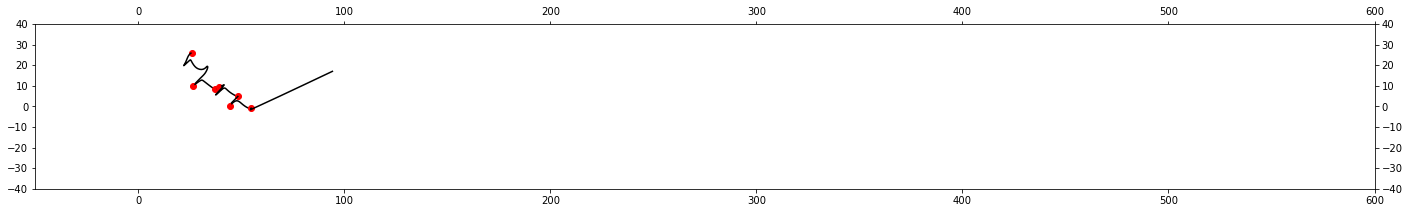

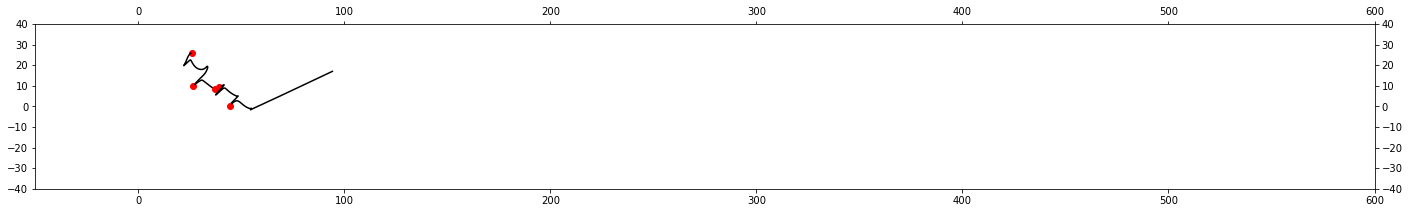

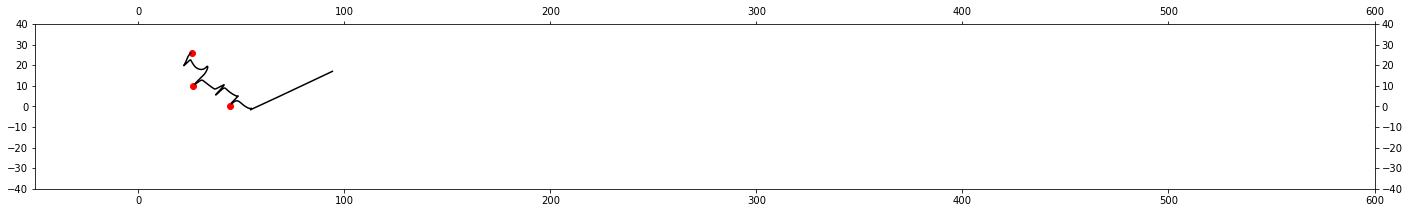

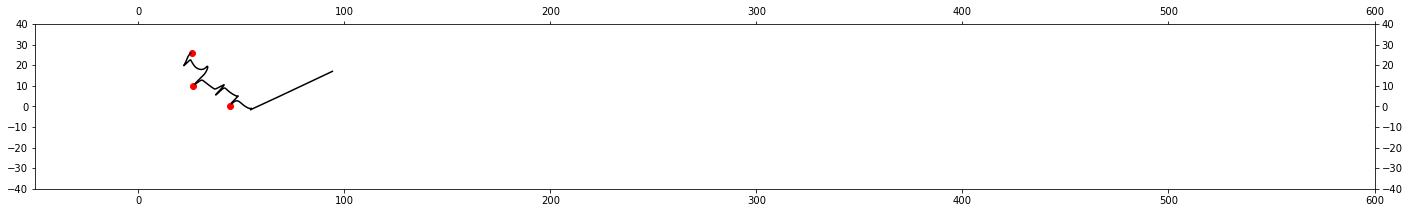

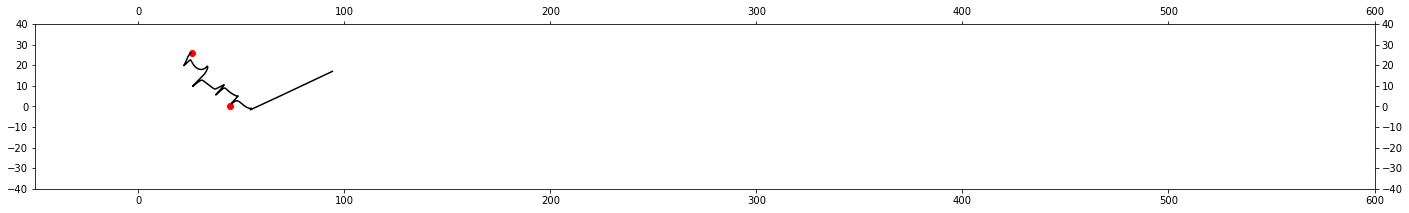

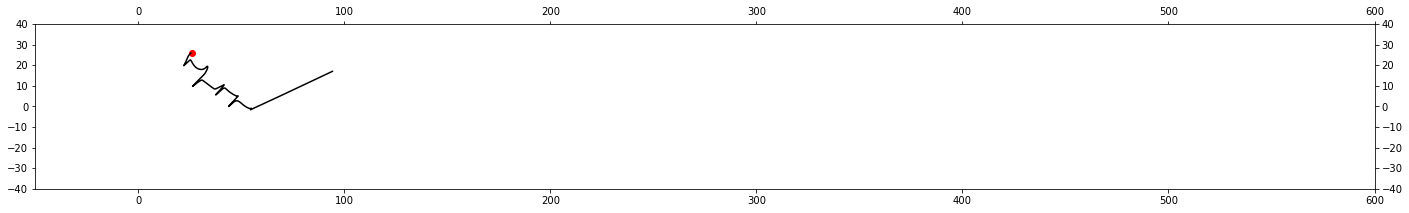

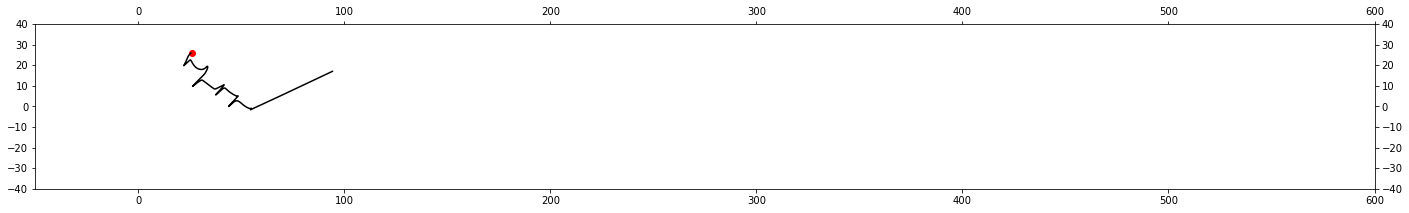

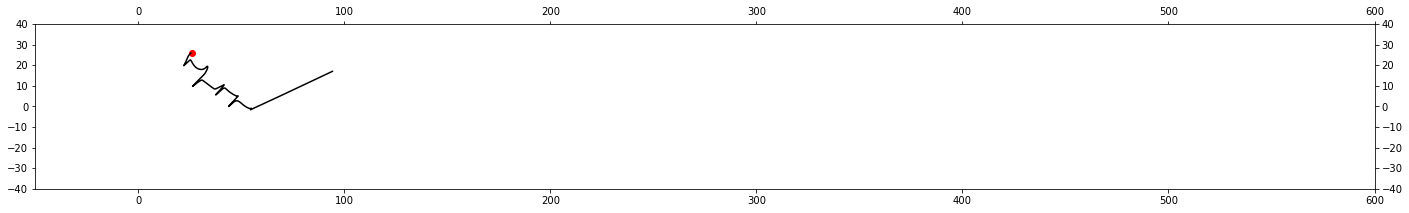

In [48]:
predictions

for threshold in np.arange(0.1, 0.9, 0.1):
    predictions_th = torch.tensor(predictions)
    predictions_th[:, 2] = predictions_th[:, 2] > threshold
    drawing.draw(predictions_th.cpu(), align_strokes=True, denoise_strokes=True)


In [ ]:
def sample(model, predictions):
    with torch.no_grad():
        start = predictions[0]
        for i in range(len(predictions)-1):
            print(model(start.unsqueeze_(0), h0, ).shape()) 
    

In [13]:
class LSTMExp(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMExp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x, h0, c0):
        return self.lstm(x, (h0, c0))
    
input_size = 3
seq_length = 12
hidden_size = 100
batch_size = 10
x = torch.rand(batch_size, seq_length, input_size)
h0 = torch.rand(1, batch_size, hidden_size)
c0 = torch.rand(1, batch_size, hidden_size)
m = LSTMExp(input_size, hidden_size)
out, (hn, cn) = m(x, h0, c0)
print(out.shape)
print(hn.shape)
print(cn.shape)

torch.save({
            'epoch': 2,
            'model_state_dict': m.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses[-1],
            }, "model_checkpoints/")

torch.Size([10, 12, 100])
torch.Size([1, 10, 100])
torch.Size([1, 10, 100])


In [46]:
MAX_SEQ_LENGTH = 1200

class HandWritingPrediction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandWritingPrediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmCell1 = nn.LSTMCell(input_size, hidden_size)
        self.lstmCell2 = nn.LSTMCell(hidden_size + input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.num_activations = 4 # 2 for each lstm layers
    
    def forward(self, x, activations, idx):
        activations_new[0], activations_new[1] = self.lstmCell1(
            x, (activations_old[0], activations_old[1]))
        activations_new[2], activations_new[3] = self.lstmCell2(
            torch.cat((x, activations_old[2]), 1), (aactivations_old[2], activations_old[3]))
        out = self.linear(activations_old[2])
        return out, activations_old, activations_new
    
    def init_hidden(self, bs, device):
        return torch.zeros(self.num_activations, bs, self.hidden_size).to(device)


In [40]:
def train(model, input_stroke, stroke_len, optimizer, loss_fnc, activations1, activations2):
    optimizer.zero_grad()
    bs = 1
    loss = 0
    for i, pt in enumerate(input_stroke[:stroke_len-1]):
        out, activations = model(pt, activations1, activations2)
        loss += loss_fnc(out, input_stroke[i+1])
    loss = loss/(stroke_len-1)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
def eval(model, input_stroke, stroke_len, loss_fnc, activations):
    with torch.no_grad():
        bs = 1
        loss = 0
        for i, pt in enumerate(input_stroke[:stroke_len-1]):
            out, activations = model(pt, activations, i)
            loss += loss_fnc(out, input_stroke[i+1])
        loss = loss/len(inputs)
        return loss

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [43]:
batch_size = 1
n_hidden = 1000
n_input = 3

model = HandWritingPrediction(n_input, n_hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

    



In [45]:
print_every = 100
n_epochs = 2
n_iters = 0
losses = []
total_loss = 0
activations = model.init_hidden(batch_size, device)

torch.autograd.set_detect_anomaly(True)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(model, strokes[0].to(device), stroke_lens.item(), optim, loss_function, activations)
        activations.zero_()
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
        n_iters += 1

[W python_anomaly_mode.cpp:104] Warning: Error detected in ThnnFusedLstmCellBackward. Traceback of forward call that caused the error:
  File "/home/miniconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/miniconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/miniconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/miniconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/miniconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  Fil

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 1000]], which is output 0 of AsStridedBackward, is at version 2049; expected version 2047 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

<Figure size 432x288 with 0 Axes>

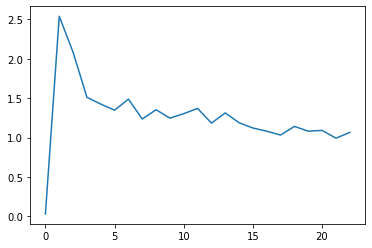

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)

In [90]:
from torch.nn.utils.rnn import pack_padded_sequence
s, l = next(iter(train_dataloader))
s.shape
l.shape
#packed = pack_padded_sequence(s, l, batch_first=True, enforce_sorted=False)

#model(packed, h, c)

torch.Size([1, 1200, 3])

torch.Size([1])

In [96]:
eval(model, s[0], l.item(), loss_function)

torch.Size([702, 1, 3])
torch.Size([702, 1, 3])
torch.Size([1, 1000])


tensor(3.1328)